# WIDS Datathon 2021

**Paticipantes**: Adriana, Camila, Graciele, Luiz

**Grupo Kaggle**: Maria Odília Teixeira

**Ponto de atenção**: O desafio deste ano se concentrará em modelos para determinar se um paciente admitido em uma **UTI** é diagnosticado com um tipo específico de diabetes, **Diabetes Mellitus**. 

Usando dados das primeiras 24 horas de terapia intensiva, indivíduos e equipes explorarão os dados de treinamento rotulados para o desenvolvimento do modelo. 

Os registros médicos podem levar dias para serem transferidos, especialmente para um paciente de outro provedor ou sistema médico.

O conhecimento sobre condições crônicas, como diabetes, pode informar as decisões clínicas sobre o atendimento ao paciente e, por fim, melhorar os resultados do paciente.

Métrica a ser encaminhada no resultado: AUC

Tipos de algoritimos comuns: **XGBoost, CatBoost, Random Forest.**

Descrição de estratégia 1º posição WiDS 2020: https://www.kaggle.com/c/widsdatathon2020/discussion/133189

Notebook: https://www.kaggle.com/danofer/wids-2020-starter-catboost-0-9045-lb

**DICA**: Separe 5% dos dados para testes antes da submição

> Aproximadamente **33% das pessoas** com diabetes são hospitalizadas durante os primeiros anos da doença por complicações agudas, passíveis de serem prevenidas com *bom controle glicêmic*o, sendo que as condições de hiperglicemia, hipoglicemia e cetoacedose diabética representam **24% das
intercorrências** no serviço de emergência(14).

## **Setup**

In [1]:
# Pandas nos permite trabajar con DataFrames
import pandas as pd
# Para la visualización de datos
import plotly.express as px
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve

# roc curve and auc score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#from sklearn import metrics as multioutput

from sklearn import metrics

%matplotlib inline
%load_ext google.colab.data_table

In [2]:
!pip install mglearn
!pip install kaggle
!mkdir ~/.kaggle
!touch '/root/.kaggle/kaggle.json'
######################################################################################
# Copia aquí tu USER NAME y API KEY de kaggle

api_token = {"username":"xxx","key":"xxx"}
######################################################################################


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 542kB 7.7MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=fcff00625188de985289f7747bdc30f3add1346aff5dc0b6dbc5b483ecbf9210
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


In [3]:
import mglearn

In [4]:
!kaggle competitions download -c widsdatathon2021

 79% 17.0M/21.5M [00:00<00:00, 38.9MB/s]
100% 21.5M/21.5M [00:00<00:00, 48.5MB/s]
  0% 0.00/90.0k [00:00<?, ?B/s]
100% 90.0k/90.0k [00:00<00:00, 74.2MB/s]
  0% 0.00/1.60M [00:00<?, ?B/s]
100% 1.60M/1.60M [00:00<00:00, 109MB/s]
  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 58.8kB/s]
  0% 0.00/28.2k [00:00<?, ?B/s]
100% 28.2k/28.2k [00:00<00:00, 76.7MB/s]


In [5]:
!unzip -o TrainingWiDS2021.csv.zip
!unzip -o UnlabeledWiDS2021.csv.zip

Archive:  TrainingWiDS2021.csv.zip
  inflating: TrainingWiDS2021.csv    
Archive:  UnlabeledWiDS2021.csv.zip
  inflating: UnlabeledWiDS2021.csv   


In [6]:
!ls

cache			      TrainingWiDS2021.csv
DataDictionaryWiDS2021.csv    TrainingWiDS2021.csv.zip
sample_data		      UnlabeledWiDS2021.csv
SampleSubmissionWiDS2021.csv  UnlabeledWiDS2021.csv.zip
SolutionTemplateWiDS2021.csv


## **Exploratório**

In [84]:
## Funções
def ler_arquivos(arquivo):
  df = pd.read_csv(arquivo)  
  print("Dimenções ",arquivo, "(filas, columnas)  : ", df.shape)
  return df

def remover_valores(df,column):
  df = df[(df[column].notnull())]
  print(df.shape)
  return df

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def missing_values(df):
  percent_missing_diabetes = df[(df['diabetes_mellitus'] == 1) ].isnull().sum() * 100 / len(df)
  percent_missing_non_diabetes = df[(df['diabetes_mellitus'] == 0) ].isnull().sum() * 100 / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing_diabetes': percent_missing_diabetes,
                                  'percent_missing_non_diabetes': percent_missing_non_diabetes}).round(2)

  missing_value_df.sort_values('percent_missing_diabetes', inplace=True)
  return missing_value_df.head(200)

def nan_values(df):
  percent_missing_diabetes = df[(df['diabetes_mellitus'] == 1) ].isna().sum() * 100 / len(df)
  percent_missing_non_diabetes = df[(df['diabetes_mellitus'] == 0) ].isna().sum() * 100 / len(df)
  missing_value_df = pd.DataFrame({'column_name': df.columns,
                                  'percent_missing_diabetes': percent_missing_diabetes,
                                  'percent_missing_non_diabetes': percent_missing_non_diabetes}).round(2)

  missing_value_df.sort_values('percent_missing_non_diabetes', inplace=True)
  return missing_value_df.head(200)

def model_performance(model,X_test, y_test, y_val_pred):
    '''Apresenta as métricas principais do modelo'''
    
    print("ACURÁCIA:                ",round(metrics.accuracy_score(y_test,y_val_pred),4))  
    print("SENSIBILIDADE:           ",round(metrics.recall_score(y_test,y_val_pred),4))
    print ("PRECISÃO:                ",round(metrics.precision_score(y_test, y_val_pred),4))
    print ("F1-SCORE:                ",round(metrics.f1_score(y_test, y_val_pred),4))
    print ("ERRO QUADRADO AJUSTADO:  ",round(metrics.adjusted_rand_score(y_test, y_val_pred),4))    
    print ("ROC SCORE:               ",round(metrics.roc_auc_score(y_test, y_val_pred),4))  
    print ("MATRIZ DE CONFUSÃO:      \n",metrics.confusion_matrix(y_test, y_val_pred))

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))
    
def fillnan_mean_gender(df,column):
  gc = df.groupby(['gender'],as_index=False).mean().round(2)

  for index, row in gc.iterrows():
    df.loc[df.gender== row['gender'],column] = df.loc[df.gender== row['gender'],column].fillna(gc[gc['gender'] == row['gender']][column].mean())
  return df

def fillnan_glucose_apache(df,column):
  gc = df.groupby(['glucose_apache'],as_index=False).mean().round(2)

  for index, row in gc.iterrows():
    df.loc[df.glucose_apache== row['glucose_apache'],column] = df.loc[df.glucose_apache== row['glucose_apache'],column].fillna(gc[gc['glucose_apache'] == row['glucose_apache']][column].mean())
  return df

def fillnan_mean_apache_3j_diagnosis(df,df_train,column):
  if column in df:
    gc = df_train.groupby(['apache_3j_diagnosis'],as_index=False).mean().round(2)

    for index, row in gc.iterrows():
      df.loc[df.apache_3j_diagnosis== row['apache_3j_diagnosis'],column] = df.loc[df.apache_3j_diagnosis== row['apache_3j_diagnosis'],column].fillna(gc[gc['apache_3j_diagnosis'] == row['apache_3j_diagnosis']][column].mean())
      
  return df

def fillnan_mean_ethnicity(df,df_train,column):
  if column in df:
    gc = df_train.groupby(['ethnicity'],as_index=False).mean().round(2)

    for index, row in gc.iterrows():
      df.loc[df.ethnicity== row['ethnicity'],column] = df.loc[df.ethnicity== row['ethnicity'],column].fillna(gc[gc['ethnicity'] == row['ethnicity']][column].mean())
      
  return df

def fillnan_mean_readmission_status(df,column):
  if column in df:
    gc = df.groupby(['readmission_status'],as_index=False).mean().round(2)

    for index, row in gc.iterrows():
      df.loc[df.readmission_status== row['readmission_status'],column] = df.loc[df.readmission_status== row['readmission_status'],column].fillna(gc[gc['readmission_status'] == row['readmission_status']][column].mean())
      
  return df

def fillnan_mean_age(df,df_train,column):
  if column in df:
    gc = df_train.groupby(['age'],as_index=False).median().round(2)

    for index, row in gc.iterrows():
      df.loc[df.age== row['age'],column] = df.loc[df.age== row['age'],column].fillna(gc[gc['age'] == row['age']][column].median())
      
  return df

def fillnan_mean_weight(df,df_train,column):
  if column in df:
    gc = df_train.groupby(['weight'],as_index=False).median().round(2)

    for index, row in gc.iterrows():
      df.loc[df.weight== row['weight'],column] = df.loc[df.age== row['weight'],column].fillna(gc[gc['weight'] == row['weight']][column].median())
      
  return df

def fillnan_mean_bmi_grp(df,df_train,column):
  if column in df:
    gc = df_train.groupby(['bmi_grp'],as_index=False).median().round(2)

    for index, row in gc.iterrows():
      df.loc[df.bmi_grp== row['bmi_grp'],column] = df.loc[df.bmi_grp== row['bmi_grp'],column].fillna(gc[gc['bmi_grp'] == row['bmi_grp']][column].median())
      
  return df

def fillnan_mean_icu_stay_type(df,df_train,column):
  if column in df:
    gc = df_train.groupby(['icu_stay_type'],as_index=False).median().round(2)

    for index, row in gc.iterrows():
      df.loc[df.icu_stay_type== row['icu_stay_type'],column] = df.loc[df.icu_stay_type== row['icu_stay_type'],column].fillna(gc[gc['icu_stay_type'] == row['icu_stay_type']][column].median())
      
  return df

def normalizar_dataset(df,df_train):

  #Exames fisiologicos - Primeira hora
  df = fillnan_mean_bmi_grp(df,df_train,"h1_lactate_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_lactate_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_bilirubin_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_bilirubin_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_pao2fio2ratio_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_pao2fio2ratio_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_creatinine_max")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_creatinine_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_bun_max")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_bun_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_diasbp_invasive_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_diasbp_invasive_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_albumin_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_albumin_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_arterial_ph_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_arterial_ph_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_arterial_pco2_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_arterial_pco2_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_arterial_po2_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_arterial_po2_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_wbc_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_wbc_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_platelets_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_platelets_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_sysbp_invasive_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_sysbp_invasive_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_mbp_invasive_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_hco3_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_hco3_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_hematocrit_max")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_hematocrit_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_calcium_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_calcium_max")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_sodium_max")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_sodium_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_potassium_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"h1_potassium_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_inr_min")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_inr_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_mbp_invasive_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_hemaglobin_max")
  df = fillnan_mean_bmi_grp(df,df_train,"h1_hemaglobin_min")

  #Exames fisiologicos - Primeira 24 horas
  df = fillnan_mean_bmi_grp(df,df_train,"d1_lactate_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_lactate_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_bilirubin_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_bilirubin_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_pao2fio2ratio_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_pao2fio2ratio_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"d1_creatinine_max")
  df = fillnan_mean_icu_stay_type(df,df_train,"d1_creatinine_min")
  df = fillnan_mean_icu_stay_type(df,df_train,"d1_bun_max")
  df = fillnan_mean_icu_stay_type(df,df_train,"d1_bun_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_diasbp_invasive_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_diasbp_invasive_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_sysbp_invasive_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_sysbp_invasive_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_mbp_invasive_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_mbp_invasive_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_arterial_ph_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_arterial_ph_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_arterial_pco2_min")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_arterial_pco2_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_inr_max")
  df = fillnan_mean_bmi_grp(df,df_train,"d1_inr_min") 
  df = fillnan_mean_bmi_grp(df,df_train,"d1_albumin_max") 
  df = fillnan_mean_bmi_grp(df,df_train,"d1_albumin_min")  
  df = fillnan_mean_bmi_grp(df,df_train,"d1_arterial_po2_min")  
  df = fillnan_mean_bmi_grp(df,df_train,"d1_arterial_po2_max")  

  #Principal feature ref. a diabetes tipo 2
  #df = fillnan_mean_bmi_grp(df,df_train,"h1_glucose_max")
  #df = fillnan_mean_bmi_grp(df,df_train,"h1_glucose_min")

  #Features individuais scores
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"urineoutput_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"bilirubin_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"ventilated_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"intubated_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"pre_icu_los_days")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"albumin_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"ph_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"paco2_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"fio2_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"paco2_for_ph_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"pao2_apache")

  # Score de Glasgow
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"gcs_motor_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"gcs_eyes_apache")
  df = fillnan_mean_apache_3j_diagnosis(df,df_train,"gcs_verbal_apache")
    
  df['gcs_sum'] = (df['gcs_motor_apache'] + df['gcs_eyes_apache'] + df['gcs_verbal_apache'])
  df['gcs_intubated'] = np.where(df['gcs_sum']<=8, 1, 0)

  #df['higth_d1_glucose_min'] = np.where(df['d1_glucose_min']>200, 1, 0)
  df['higth_h1_glucose_min'] = np.where(df['h1_glucose_min']>200, 1, 0)

  #Utilizar o bmi (age)
  df['higth_80_weight'] = np.where(df['weight']>=80, 1, 0)
  
  #Calculo IMC vs Idade
  df['age_bmi'] = df['age']/df['bmi']

  #df = df.drop('d1_glucose_max',axis = 1)
  #df = df.drop('h1_glucose_max',axis = 1)
  #df = df.drop('weight',axis = 1)
  #df = df.drop('gcs_sum',axis = 1)

  return df

In [8]:
df_training          = ler_arquivos('TrainingWiDS2021.csv')
df_unlabeled         = ler_arquivos('UnlabeledWiDS2021.csv')
df_samplesubmission  = ler_arquivos('SampleSubmissionWiDS2021.csv')
df_solution_template = ler_arquivos('SolutionTemplateWiDS2021.csv')
df_wids_dict         = ler_arquivos('DataDictionaryWiDS2021.csv')

Dimenções  TrainingWiDS2021.csv (filas, columnas)  :  (130157, 181)
Dimenções  UnlabeledWiDS2021.csv (filas, columnas)  :  (10234, 180)
Dimenções  SampleSubmissionWiDS2021.csv (filas, columnas)  :  (3, 2)
Dimenções  SolutionTemplateWiDS2021.csv (filas, columnas)  :  (10234, 2)
Dimenções  DataDictionaryWiDS2021.csv (filas, columnas)  :  (181, 6)


In [9]:
df_training.head(3).transpose()

0        1        2
Unnamed: 0                         1        2        3
encounter_id                  214826   246060   276985
hospital_id                      118       81      118
age                               68       77       25
bmi                          22.7328  27.4219  31.9527
...                              ...      ...      ...
immunosuppression                  0        0        0
leukemia                           0        0        0
lymphoma                           0        0        0
solid_tumor_with_metastasis        0        0        0
diabetes_mellitus                  1        1        0

[181 rows x 3 columns]

In [10]:
#Apagar coluna "Unnamed: 0"
df_training.drop(df_training.columns[0], axis=1, inplace=True)
df_unlabeled.drop(df_unlabeled.columns[0], axis=1, inplace=True)

In [11]:
df_training.describe().transpose()

count  ...           max
encounter_id                 130157.0  ...  279000.00000
hospital_id                  130157.0  ...     204.00000
age                          125169.0  ...      89.00000
bmi                          125667.0  ...      67.81499
elective_surgery             130157.0  ...       1.00000
...                               ...  ...           ...
immunosuppression            130157.0  ...       1.00000
leukemia                     130157.0  ...       1.00000
lymphoma                     130157.0  ...       1.00000
solid_tumor_with_metastasis  130157.0  ...       1.00000
diabetes_mellitus            130157.0  ...       1.00000

[174 rows x 8 columns]

In [12]:
df_unlabeled.describe().transpose()

count           mean  ...        75%         max
encounter_id                 10234.0  140498.779461  ...  143252.75  146000.000
hospital_id                  10234.0   10092.391929  ...   10145.00   10199.000
age                          10234.0      62.853625  ...      76.00      96.000
bmi                           9219.0      29.116463  ...      32.60      69.944
elective_surgery             10234.0       0.200117  ...       0.00       1.000
...                              ...            ...  ...        ...         ...
hepatic_failure              10234.0       0.010064  ...       0.00       1.000
immunosuppression            10234.0       0.022572  ...       0.00       1.000
leukemia                     10234.0       0.006547  ...       0.00       1.000
lymphoma                     10234.0       0.004104  ...       0.00       1.000
solid_tumor_with_metastasis  10234.0       0.017686  ...       0.00       1.000

[173 rows x 8 columns]

Com a avaliação acima, podemos constatar que **21%** da base apresentam este tipo de diabete (tipo2).

### **Avaliar dos Missings***

In [13]:
missing_values(df_training)

column_name  ...  percent_missing_non_diabetes
encounter_id            encounter_id  ...                          0.00
lymphoma                    lymphoma  ...                          0.00
leukemia                    leukemia  ...                          0.00
immunosuppression  immunosuppression  ...                          0.00
hepatic_failure      hepatic_failure  ...                          0.00
...                              ...  ...                           ...
h1_lactate_min        h1_lactate_min  ...                         71.47
h1_albumin_min        h1_albumin_min  ...                         71.77
h1_albumin_max        h1_albumin_max  ...                         71.77
h1_bilirubin_min    h1_bilirubin_min  ...                         72.22
h1_bilirubin_max    h1_bilirubin_max  ...                         72.22

[180 rows x 3 columns]

**Ver tratativa de miising dos TOP3 ano passado**

In [14]:
df_training.shape

(130157, 180)

### ***Tratar Dummies***

In [15]:
df_training          = ler_arquivos('TrainingWiDS2021.csv')
df_unlabeled         = ler_arquivos('UnlabeledWiDS2021.csv')
df_samplesubmission  = ler_arquivos('SampleSubmissionWiDS2021.csv')
df_solution_template = ler_arquivos('SolutionTemplateWiDS2021.csv')
df_wids_dict         = ler_arquivos('DataDictionaryWiDS2021.csv')

#Apagar coluna "Unnamed: 0"
df_training.drop(df_training.columns[0], axis=1, inplace=True)
df_unlabeled.drop(df_unlabeled.columns[0], axis=1, inplace=True)

Dimenções  TrainingWiDS2021.csv (filas, columnas)  :  (130157, 181)
Dimenções  UnlabeledWiDS2021.csv (filas, columnas)  :  (10234, 180)
Dimenções  SampleSubmissionWiDS2021.csv (filas, columnas)  :  (3, 2)
Dimenções  SolutionTemplateWiDS2021.csv (filas, columnas)  :  (10234, 2)
Dimenções  DataDictionaryWiDS2021.csv (filas, columnas)  :  (181, 6)


In [16]:
from IPython.display import display
pd.set_option('display.max_columns', 100)
pd.options.display.max_columns = 100

cat_var = [key for key in dict(df_training.dtypes)
             if dict(df_training.dtypes)[key] in ['object'] ]

print('Features categoricas ',cat_var)

Features categoricas  ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']


In [17]:
df_training.ethnicity.unique()

array(['Caucasian', nan, 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'], dtype=object)

In [18]:
df_training['ethnicity_'] = df_training['ethnicity']
df_unlabeled['ethnicity_'] = df_unlabeled['ethnicity']

replace_map = {'ethnicity': {'Caucasian': 1, 'Hispanic': 2, 'African American': 3, 'Asian': 4,'Native American': 5,'Other/Unknown': 6}}
labels = df_training['ethnicity'].astype('category').cat.categories.tolist()
replace_map_comp = {'ethnicity' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [19]:
df_training.gender.unique()

array(['M', 'F', nan], dtype=object)

In [20]:
df_training['gender_'] = df_training['gender']
df_unlabeled['gender_'] = df_unlabeled['gender']

replace_map = {'gender': {'M': 1, 'F': 2}}
labels = df_training['gender'].astype('category').cat.categories.tolist()
replace_map_comp = {'gender' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [21]:
df_training.hospital_admit_source.unique()

array(['Floor', 'Emergency Department', 'Operating Room', nan,
       'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU',
       'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)',
       'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other'],
      dtype=object)

In [22]:
df_training['hospital_admit_source_'] = df_training['hospital_admit_source']
df_unlabeled['hospital_admit_source_'] = df_unlabeled['hospital_admit_source']

df_training_temp = df_training

df_training = pd.get_dummies(df_training_temp, columns=['hospital_admit_source'])
df_unlabeled = pd.get_dummies(df_unlabeled, columns=['hospital_admit_source'])

'''
replace_map = {'hospital_admit_source': {'Floor': 1, 'Emergency Department': 2, 'Operating Room': 3, 'Direct Admit': 4,'Other Hospital': 5,'Other ICU': 6
                                      , 'ICU to SDU': 7, 'Recovery Room ': 8, 'Chest Pain Center': 9,'Step-Down Unit (SDU)': 10, 'Acute Care/Floor': 11
                                      , 'PACU': 12, 'Observation': 13, 'Acute Care/Floor': 14, 'AICU': 15,'Other': 16 }}
labels = df_training['hospital_admit_source'].astype('category').cat.categories.tolist()
replace_map_comp = {'hospital_admit_source' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)
'''

"\nreplace_map = {'hospital_admit_source': {'Floor': 1, 'Emergency Department': 2, 'Operating Room': 3, 'Direct Admit': 4,'Other Hospital': 5,'Other ICU': 6\n                                      , 'ICU to SDU': 7, 'Recovery Room ': 8, 'Chest Pain Center': 9,'Step-Down Unit (SDU)': 10, 'Acute Care/Floor': 11\n                                      , 'PACU': 12, 'Observation': 13, 'Acute Care/Floor': 14, 'AICU': 15,'Other': 16 }}\nlabels = df_training['hospital_admit_source'].astype('category').cat.categories.tolist()\nreplace_map_comp = {'hospital_admit_source' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}\n\ndf_training.replace(replace_map_comp, inplace=True)\ndf_unlabeled.replace(replace_map_comp, inplace=True)\n"

In [23]:
df_training.icu_admit_source.unique()

array(['Floor', 'Accident & Emergency', 'Operating Room / Recovery',
       'Other Hospital', 'Other ICU', nan], dtype=object)

In [24]:
df_training['icu_admit_source_']  = df_training['icu_admit_source']
df_unlabeled['icu_admit_source_'] = df_unlabeled['icu_admit_source']

replace_map = {'icu_admit_source': {'Floor': 1, 'Accident & Emergency': 2, 'Operating Room / Recovery': 3, 'Other Hospital': 4,'Other ICU': 5}}
labels = df_training['icu_admit_source'].astype('category').cat.categories.tolist()
replace_map_comp = {'icu_admit_source' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [25]:
df_training.icu_stay_type.unique()

array(['admit', 'readmit', 'transfer'], dtype=object)

In [26]:
df_training['icu_stay_type_']  = df_training['icu_stay_type']
df_unlabeled['icu_stay_type_'] = df_unlabeled['icu_stay_type']

replace_map = {'icu_stay_type': {'admit': 1, 'readmit': 2, 'transfer': 3}}
labels = df_training['icu_stay_type'].astype('category').cat.categories.tolist()
replace_map_comp = {'icu_stay_type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [27]:
df_training.icu_type.unique()

array(['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU',
       'Cardiac ICU', 'CSICU'], dtype=object)

In [28]:
df_training['icu_type_']  = df_training['icu_type']
df_unlabeled['icu_type_'] = df_unlabeled['icu_type']

replace_map = {'icu_type': {'CTICU': 1, 'Med-Surg ICU': 2, 'Med-Surg ICU': 3, 'Neuro ICU': 4,'MICU': 5, 'SICU' : 6, 'Cardiac ICU': 7 ,'CSICU' : 8}}
labels = df_training['icu_type'].astype('category').cat.categories.tolist()
replace_map_comp = {'icu_type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

df_training.replace(replace_map_comp, inplace=True)
df_unlabeled.replace(replace_map_comp, inplace=True)

In [29]:
#Deve retornar apenas as categorias com "*_"
cat_var = [key for key in dict(df_training.dtypes)
             if dict(df_training.dtypes)[key] in ['object'] ]

print('Features categoricas ',cat_var)

Features categoricas  ['ethnicity_', 'gender_', 'hospital_admit_source_', 'icu_admit_source_', 'icu_stay_type_', 'icu_type_']


In [30]:
print('Training', df_training.shape)
print('Solution', df_unlabeled.shape) #-1 variável targuet

Training (130157, 200)
Solution (10234, 194)


In [31]:
df_unlabeled = df_unlabeled.reindex(columns = df_training.columns, fill_value=0)

In [32]:
print('Training', df_training.shape)
print('Solution', df_unlabeled.shape)

Training (130157, 200)
Solution (10234, 200)


## **Tratamento NAs** (Não necessario reexecutar)

Os dados faltantes acima de 60% somam 45 variáveis de 181 features existentes. Representando **24%** dos campos da base.

#### Análise das principais variáveis que estão relacionadas a diabete tipo 2 (mellitus)

- **weight**: The weight (body mass) of the person on unit admission
  - Pessoas com o peso acima de 80kg aprox. tem mais prob. de ter esta diabete

- **bun_apache**: 	The blood urea nitrogen concentration measured during the first 24 hours which results in the highest APACHE III score
  - Score apache para determinar a concentração de nitrogênio da uréia no sangue, para pacientes com diabetes tipo 2 este exame é alto, acima de 200 na média enquanto para pacientes sem diabetes este exame em média é próximo de 100

- **creatinine_apache**: 	The creatinine concentration measured during the first 24 hours which results in the highest APACHE III score
  - ***Wiki***: A creatinina é um produto da degradação da fosfocreatina no músculo, e é geralmente produzida em uma taxa praticamente constante pelo corpo — taxa diretamente proporcional à massa muscular da pessoa: quanto maior a massa muscular, maior a taxa.
  - Há muitos outliers neste campo, porém a média de quem tem diabetes é mais alta neste ponto comparado com os pacientes que não tem diabetes

- **glucose_apache**: The glucose concentration measured during the first 24 hours which results in the highest APACHE III score
  - É o exame que em grande maioria dos pacientes define que um paciente tem diabetes ou não.
  Wiki: Normal blood glucose level (tested while fasting) for non-diabetics is between 3.9 and 7.1 mmol/L (70 to 130 mg/dL). The global mean fasting plasma blood glucose level in humans is about 5.5 mmol/L (100 mg/dL); however, this level fluctuates throughout the day.

- **d1_sysbp_max**: The patient's highest systolic blood pressure during the first 24 hours of their unit stay, either non-invasively or invasively measured
- **d1_bun_max/min**: The highest/lowest blood urea nitrogen concentration of the patient in their serum or plasma during the first 24 hours of their unit stay
- **h1_bun_max**: The highest blood urea nitrogen concentration of the patient in their serum or plasma during the first hour of their unit stay

- **d1_glucose_max/min**: The highest/lowest glucose concentration of the patient in their serum or plasma during the first 24 hours of their unit stay

- **h1_glucose_max/min**: The highest/lowest glucose concentration of the patient in their serum or plasma during the first hour of their unit stay

- **d1_hemaglobin_max**: 	The highest hemoglobin concentration for the patient during the first 24 hours of their unit stay

- **d1_potassium_max**: The highest potassium concentration for the patient in their serum or plasma during the first 24 hours of their unit stay

In [ ]:
#Gráficos de dispersão para análise, mas um pouco pesado

#g = sns.FacetGrid(df_training_z, col="variable", sharey=False, col_wrap=3)
#g.map_dataframe(sns.boxplot, x="diabetes_mellitus", y="value")

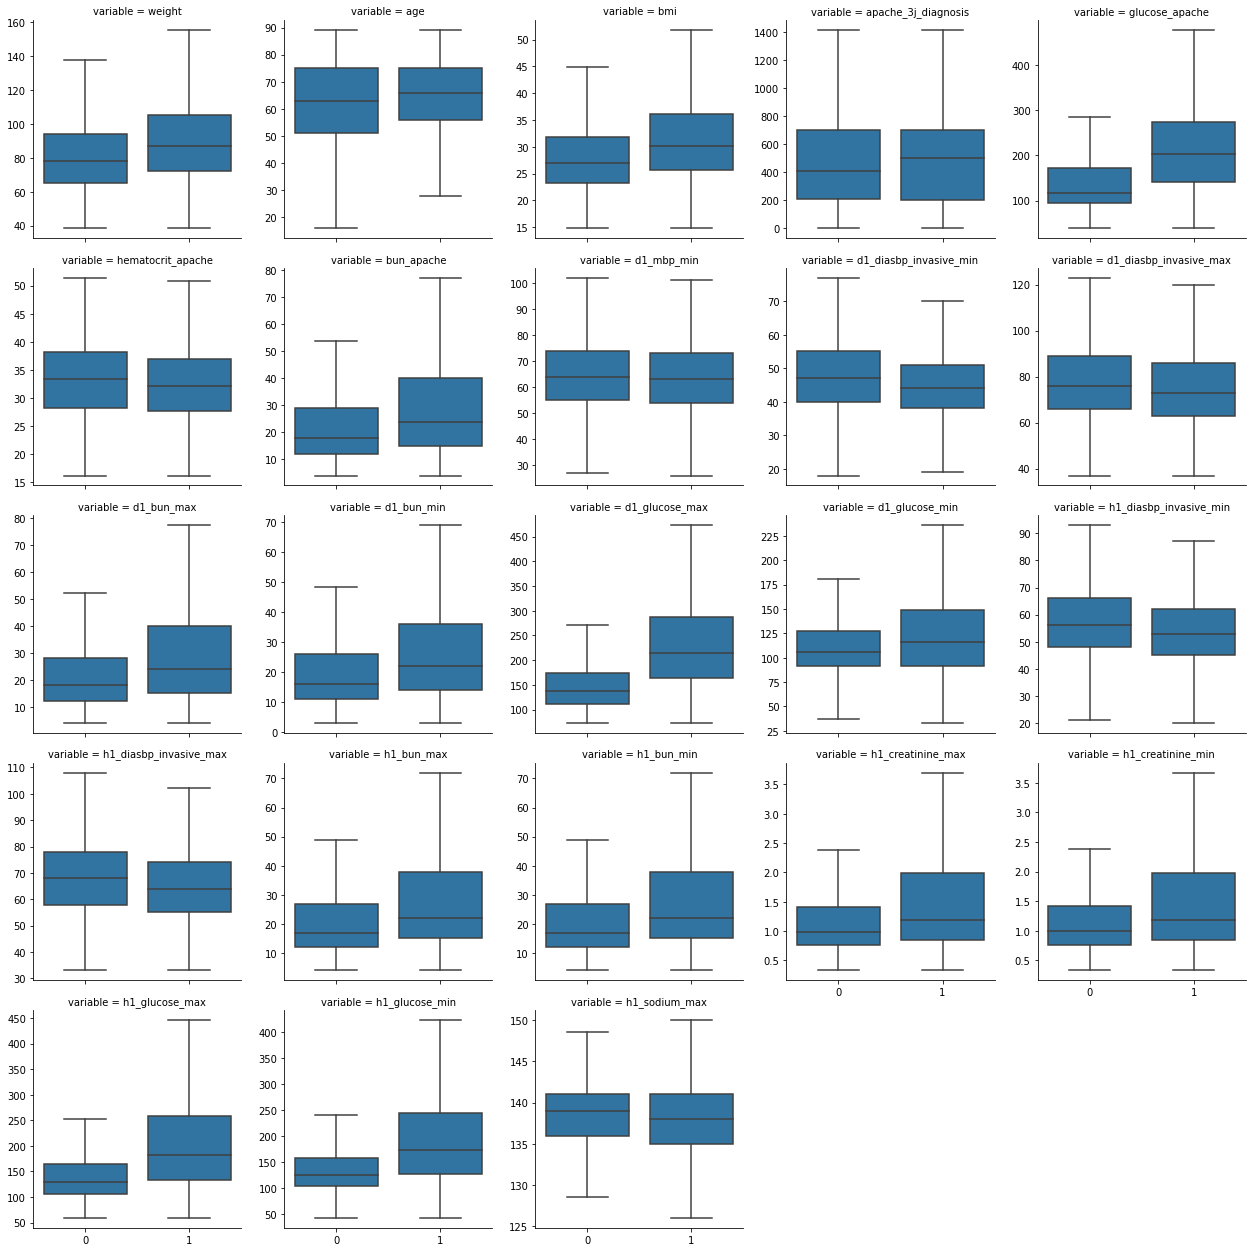

In [ ]:
# Construindo Boxplots por target com alta mudança na mediana

df_training_temp = pd.melt(df_training[['diabetes_mellitus'
                                        ,'weight','age','bmi'
                                        ,'apache_3j_diagnosis','glucose_apache','hematocrit_apache','bun_apache'
                                        ,'d1_mbp_min','bun_apache','d1_diasbp_invasive_min','d1_diasbp_invasive_max','d1_bun_max','d1_bun_min','d1_glucose_max','d1_glucose_min'
                                        ,'h1_diasbp_invasive_min','h1_diasbp_invasive_max','h1_bun_max','h1_bun_min','h1_creatinine_max','h1_creatinine_min','h1_glucose_max','h1_glucose_min','h1_sodium_max']], 
                                        id_vars='diabetes_mellitus')

# sharey=False (Escala livre)
g = sns.FacetGrid(df_training_temp, col="variable", sharey=False, col_wrap=5,  height=3.5)
g.map_dataframe(sns.boxplot, x="diabetes_mellitus", y="value", showfliers=False)

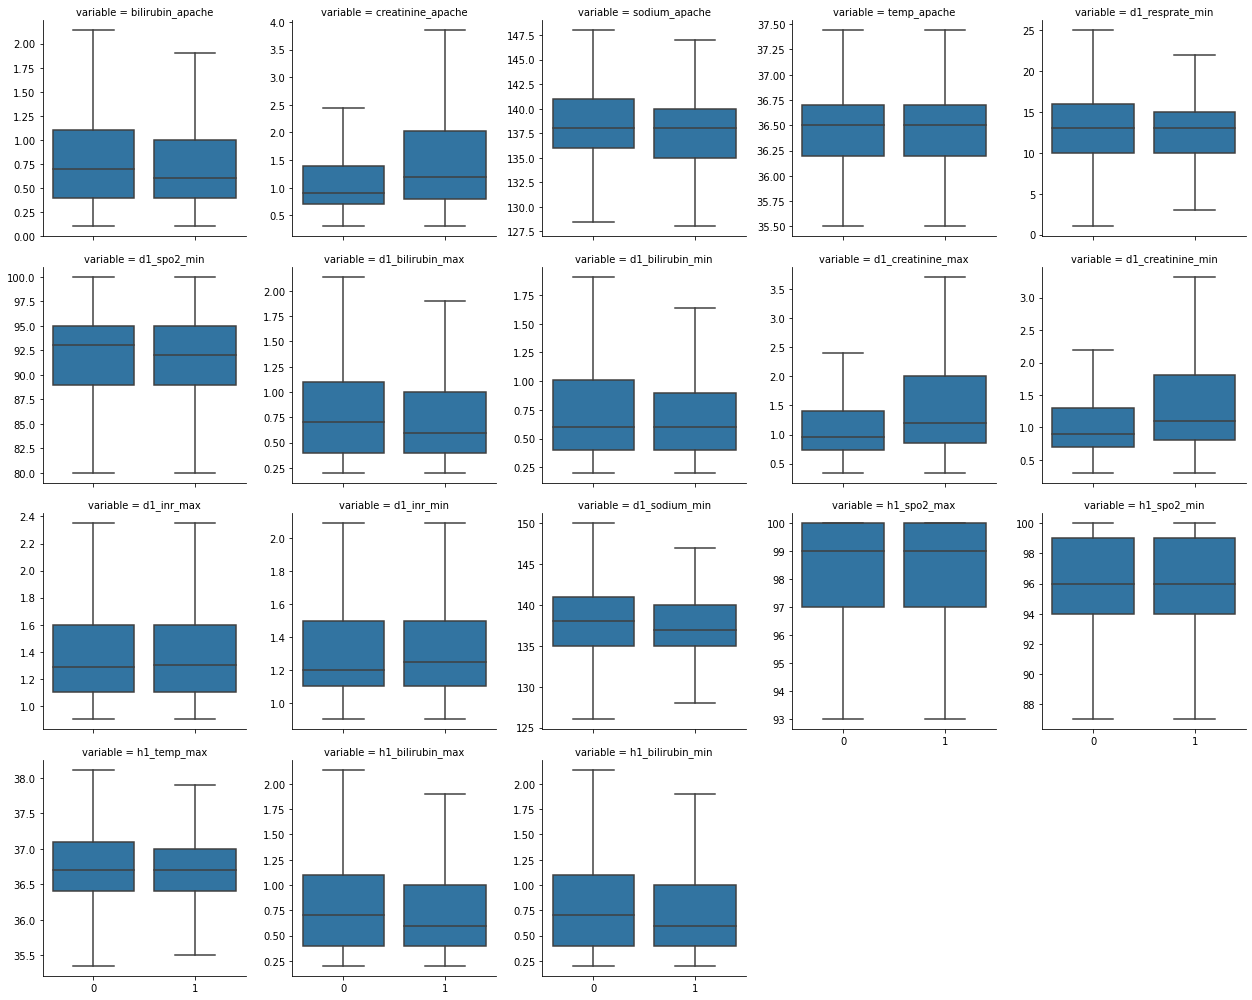

In [ ]:
# Construindo Boxplots por target para analise dos outliers

df_training_temp = pd.melt(df_training[['diabetes_mellitus'
                                        ,'bilirubin_apache','creatinine_apache','sodium_apache','temp_apache'
                                        ,'d1_resprate_min','d1_spo2_min','d1_bilirubin_max','d1_bilirubin_min','d1_creatinine_max','d1_creatinine_min','d1_inr_max','d1_inr_min','d1_sodium_min'
                                        ,'h1_spo2_max','h1_spo2_min','h1_temp_max','h1_bilirubin_max','h1_bilirubin_min']], 
                                        id_vars='diabetes_mellitus')

# sharey=False (Escala livre)
g = sns.FacetGrid(df_training_temp, col="variable", sharey=False, col_wrap=5,  height=3.5)
g.map_dataframe(sns.boxplot, x="diabetes_mellitus", y="value", showfliers=False)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:64: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



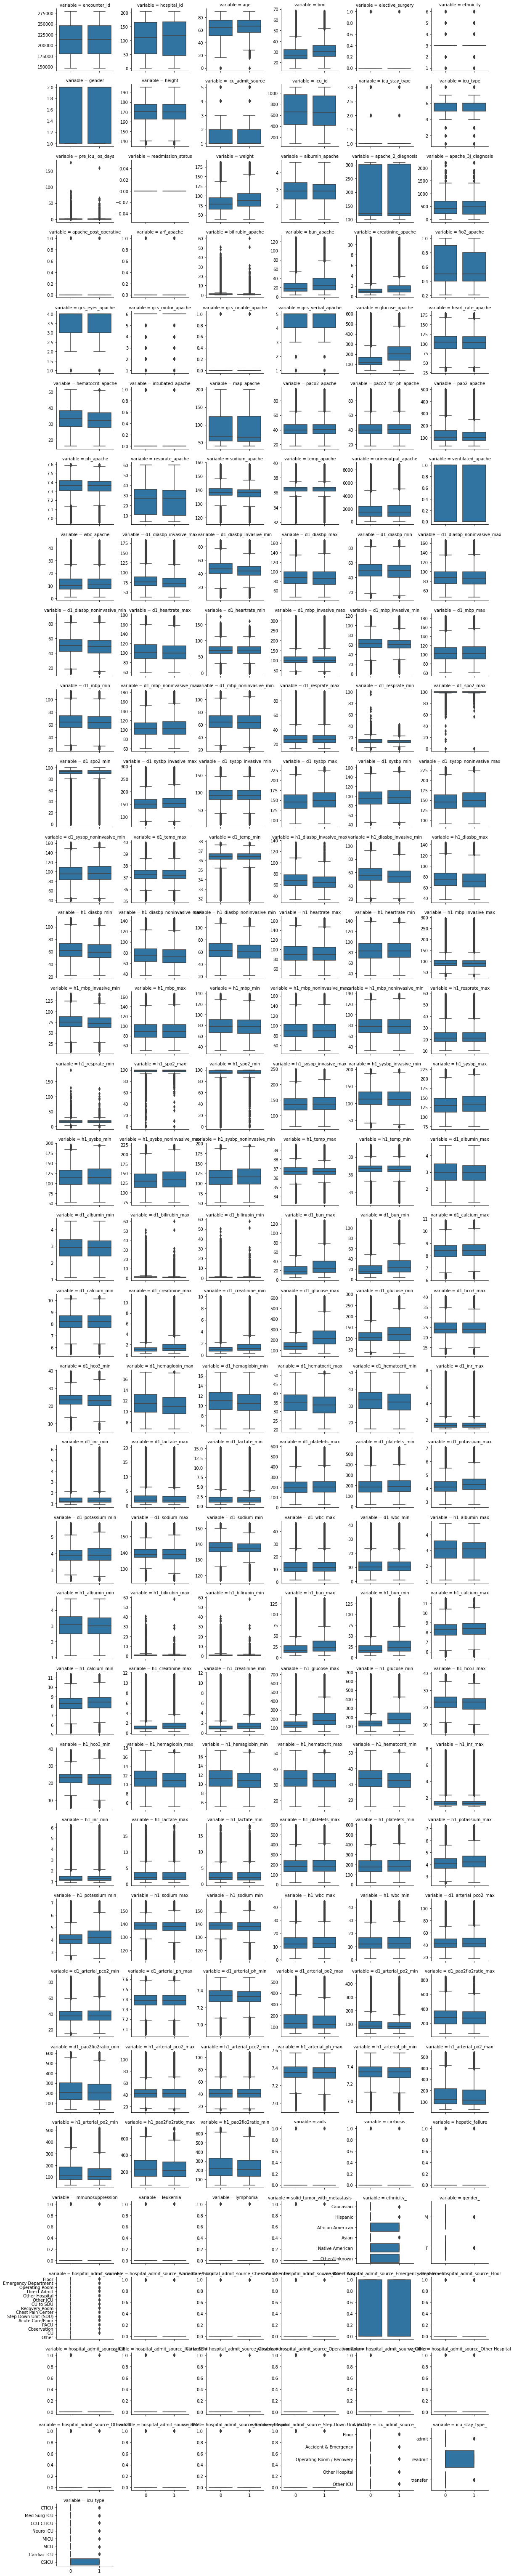

In [ ]:
# Construindo Boxplots por target

#g.set(xlim=(100, 600), ylim=(100, 600));

# Empilha as variáveis uma embaixo da outro, construindo uma tabela com 2 colunas: variávele valor
#df_training_z = pd.melt(df_training, id_vars='diabetes_mellitus')

# sharey=False (Escala livre)
#g = sns.FacetGrid(df_training_z, col="variable", sharey=False, col_wrap=6,  height=2.5)
#g.map_dataframe(sns.boxplot, x="diabetes_mellitus", y="value")

Análises das variáveis com maior número de nulos vs. objetivo para definir quando um paciente está com **diabetes tipo 2**



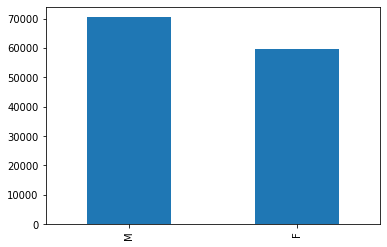

In [ ]:
tab = df_training['gender_'].value_counts()

#Gráfico de Barras
tab.plot(kind='bar')

In [ ]:
fx = pd.crosstab(df_training["gender_"],df_training["diabetes_mellitus"], normalize='index')
fx

diabetes_mellitus         0         1
gender_                              
F                  0.786380  0.213620
M                  0.781332  0.218668

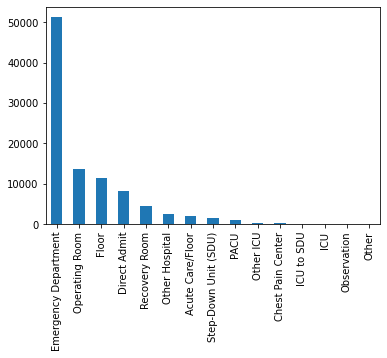

In [ ]:
tab = df_training['hospital_admit_source_'].value_counts()

#Gráfico de Barras
tab.plot(kind='bar')

In [ ]:
fx = pd.crosstab(df_training["hospital_admit_source_"],df_training["diabetes_mellitus"], normalize='index')
fx

diabetes_mellitus              0         1
hospital_admit_source_                    
Acute Care/Floor        0.752980  0.247020
Chest Pain Center       0.841897  0.158103
Direct Admit            0.779595  0.220405
Emergency Department    0.786199  0.213801
Floor                   0.781173  0.218827
ICU                     0.891892  0.108108
ICU to SDU              0.758065  0.241935
Observation             0.800000  0.200000
Operating Room          0.786073  0.213927
Other                   1.000000  0.000000
Other Hospital          0.812578  0.187422
Other ICU               0.848057  0.151943
PACU                    0.794374  0.205626
Recovery Room           0.818540  0.181460
Step-Down Unit (SDU)    0.754200  0.245800

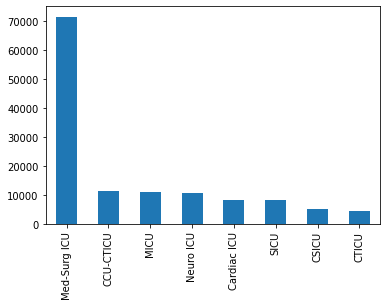

In [ ]:
tab = df_training['icu_type_'].value_counts()

#Gráfico de Barras
tab.plot(kind='bar')

In [ ]:
fx = pd.crosstab(df_training["icu_stay_type_"],df_training["diabetes_mellitus"], normalize='index')
fx

diabetes_mellitus         0         1
icu_type_                            
CCU-CTICU          0.771569  0.228431
CSICU              0.722144  0.277856
CTICU              0.761001  0.238999
Cardiac ICU        0.781537  0.218463
MICU               0.761513  0.238487
Med-Surg ICU       0.782868  0.217132
Neuro ICU          0.840786  0.159214
SICU               0.815815  0.184185

## **Análise de Correlações** (Não necessário reexecutar)

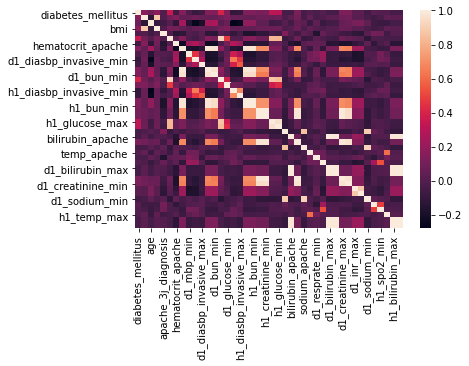

In [ ]:
# Mapa de calor da matriz de correlação, usando seaboarn (sns)
df_training_cor = df_training[['diabetes_mellitus'
                                ,'weight','age','bmi'
                                ,'apache_3j_diagnosis','glucose_apache','hematocrit_apache','bun_apache'
                                ,'d1_mbp_min','d1_diasbp_invasive_min','d1_diasbp_invasive_max','d1_bun_max','d1_bun_min','d1_glucose_max','d1_glucose_min'
                                ,'h1_diasbp_invasive_min','h1_diasbp_invasive_max','h1_bun_max','h1_bun_min','h1_creatinine_max','h1_creatinine_min','h1_glucose_max','h1_glucose_min','h1_sodium_max'
                                 ,'bilirubin_apache','creatinine_apache','sodium_apache','temp_apache'
                                ,'d1_resprate_min','d1_spo2_min','d1_bilirubin_max','d1_bilirubin_min','d1_creatinine_max','d1_creatinine_min','d1_inr_max','d1_inr_min','d1_sodium_min'
                                ,'h1_spo2_max','h1_spo2_min','h1_temp_max','h1_bilirubin_max','h1_bilirubin_min']]

sns.heatmap(df_training_cor.corr())

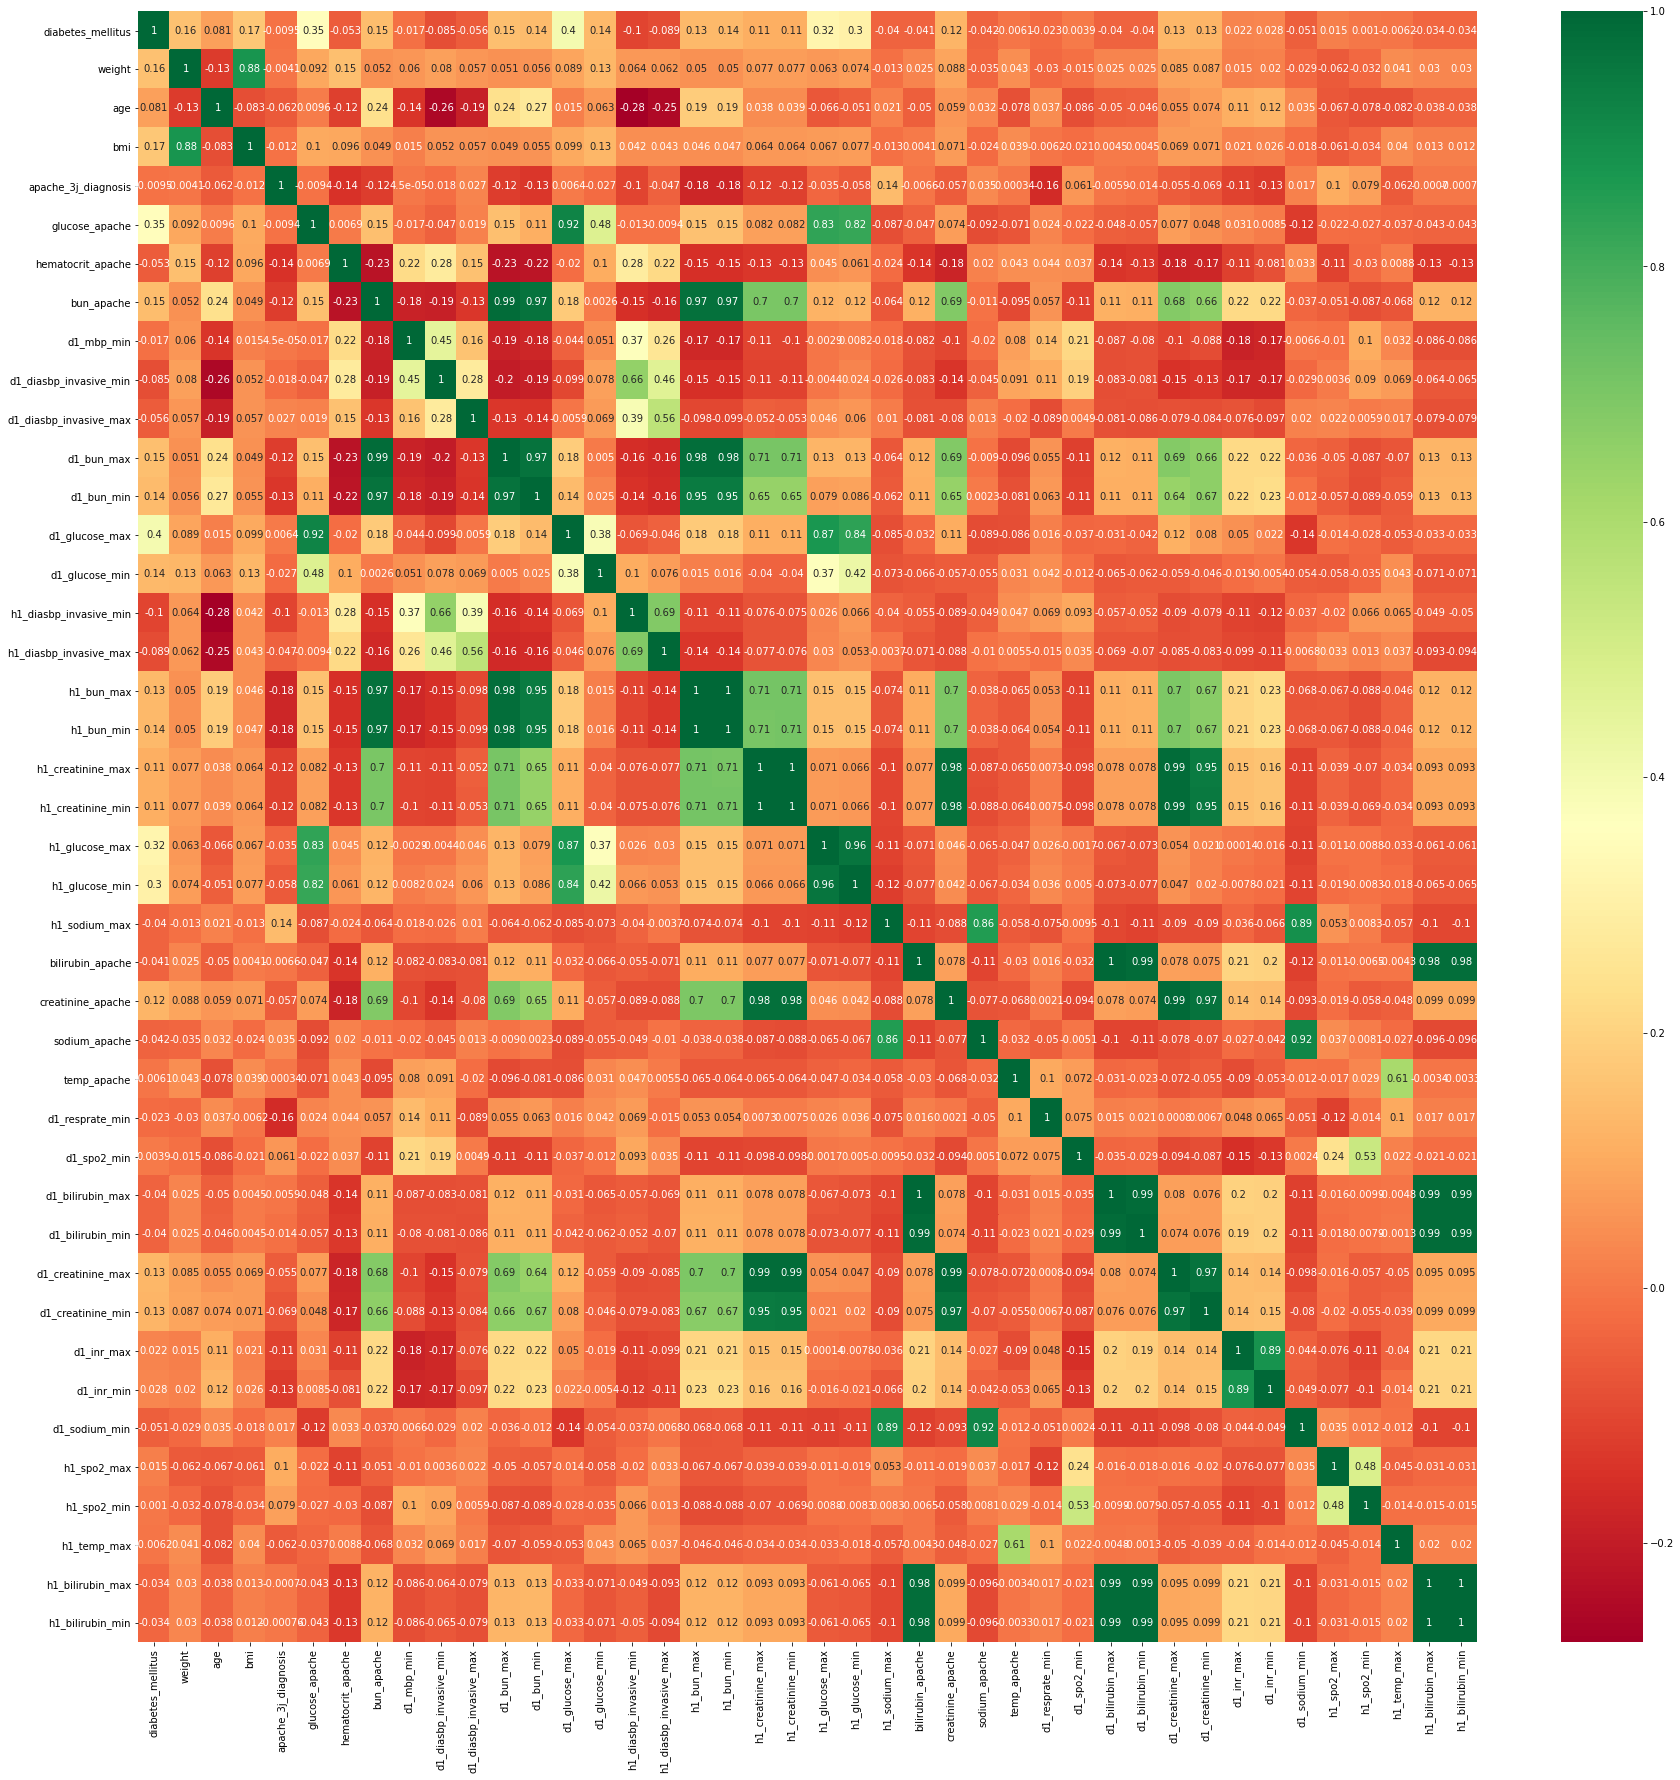

In [ ]:
df = df_training_cor

target = df_training_cor['diabetes_mellitus']

#get correlations of each features in dataset
corrmat = df.corr(method ='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))

#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

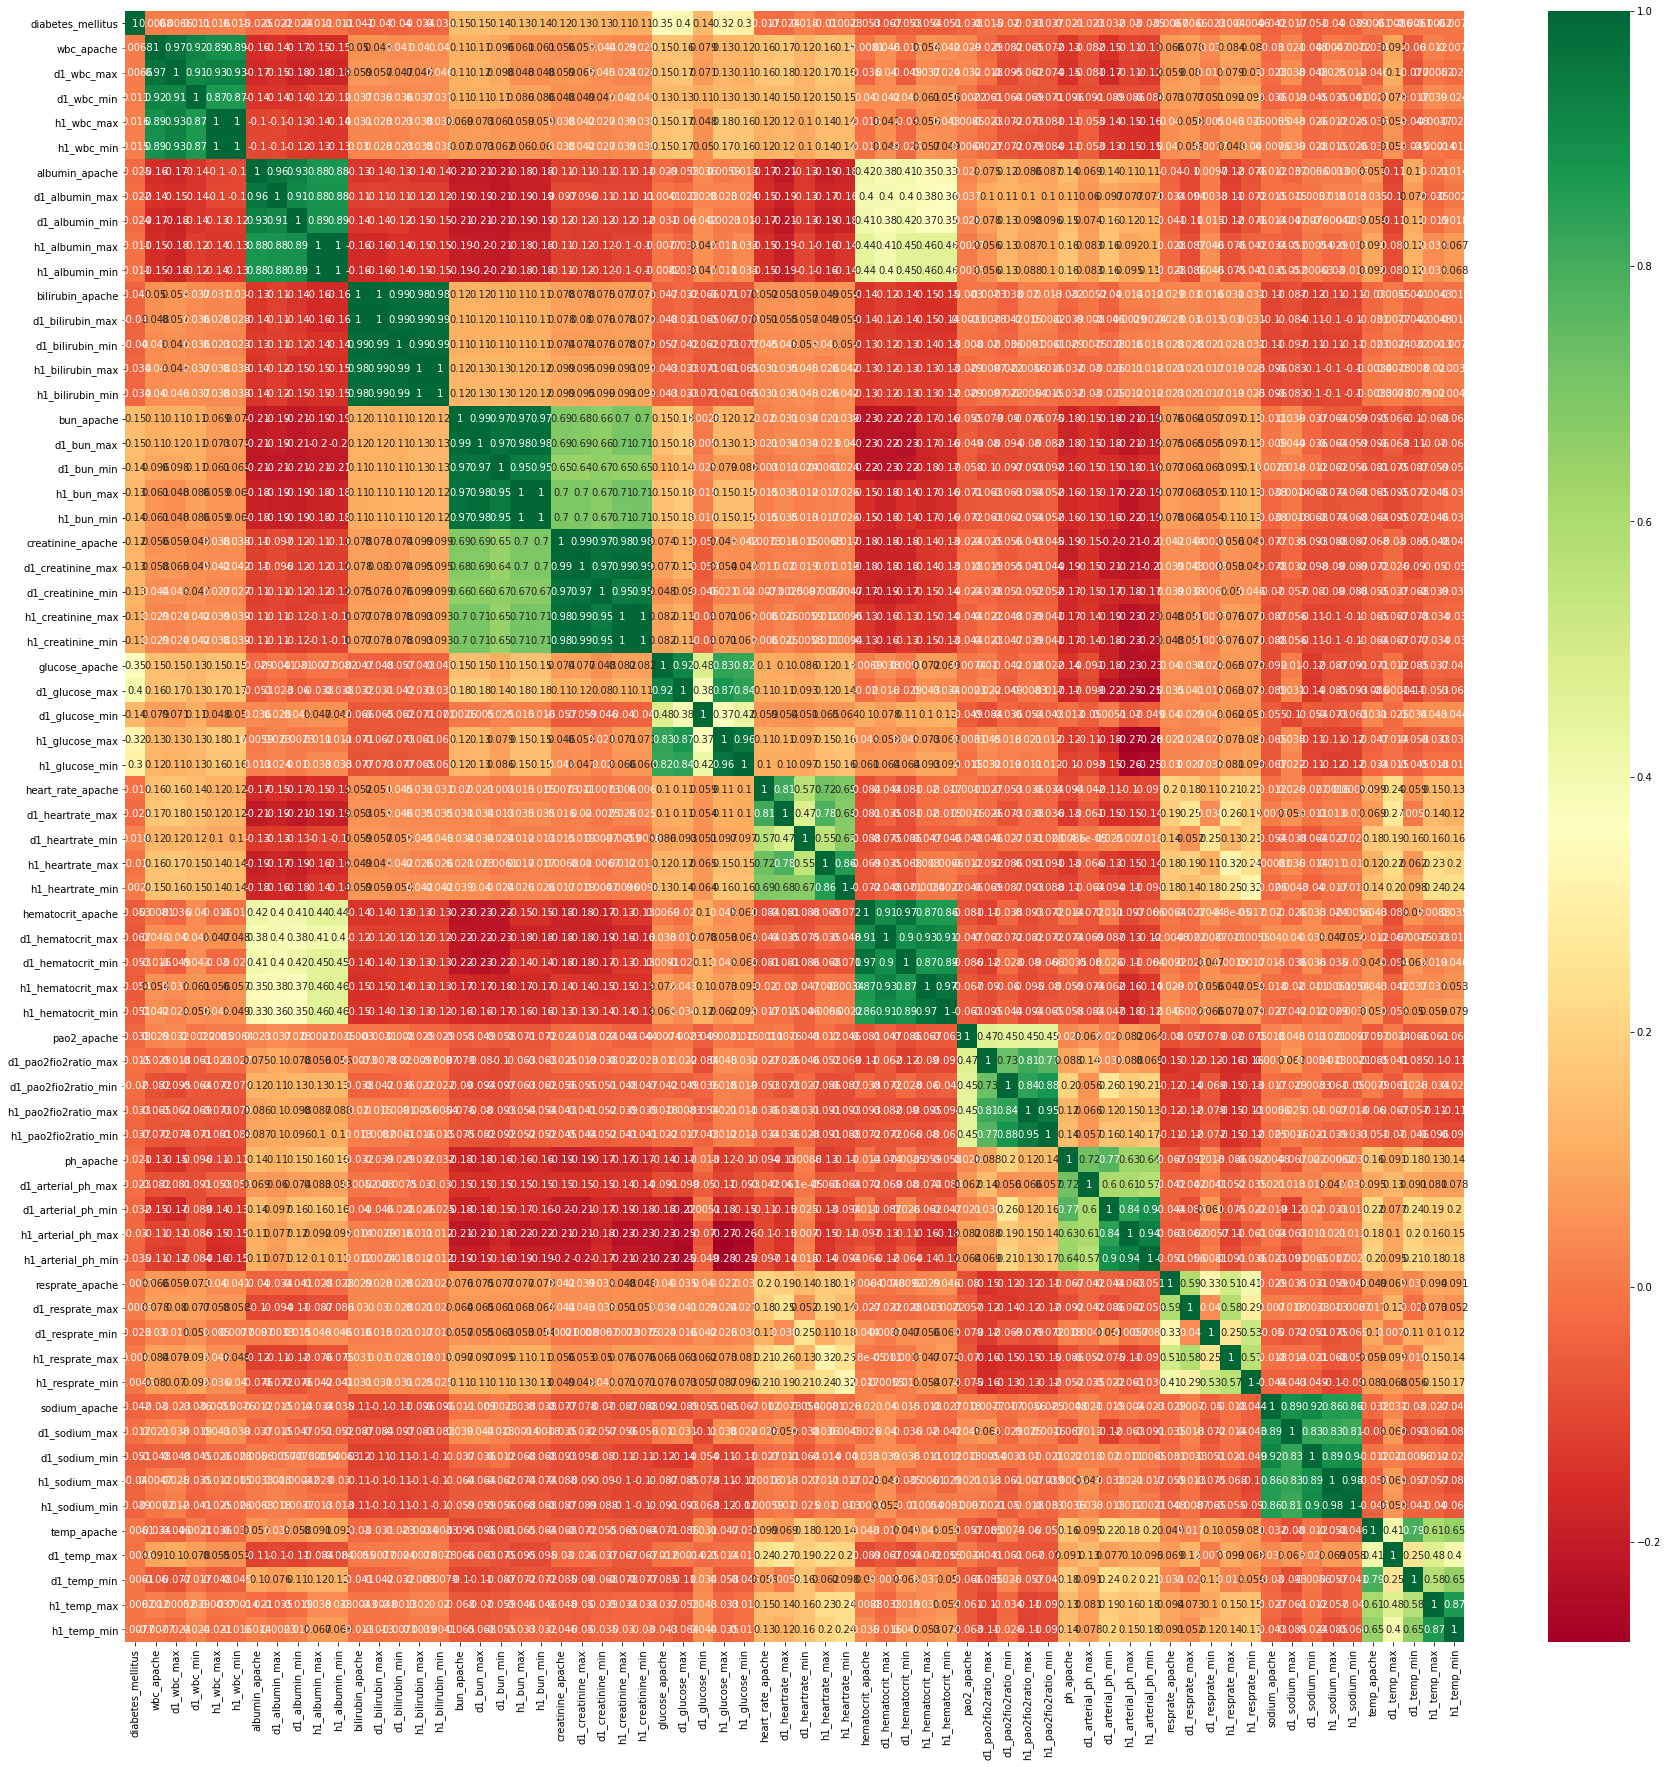

In [ ]:
## Avaliar possiveis problemas de multicolinearidade
df = df_training[['diabetes_mellitus'
                  ,'wbc_apache','d1_wbc_max','d1_wbc_min','h1_wbc_max','h1_wbc_min'
                  ,'albumin_apache','d1_albumin_max','d1_albumin_min','h1_albumin_max','h1_albumin_min'
                  ,'bilirubin_apache','d1_bilirubin_max','d1_bilirubin_min','h1_bilirubin_max','h1_bilirubin_min'
                  ,'bun_apache','d1_bun_max','d1_bun_min','h1_bun_max','h1_bun_min'
                  ,'creatinine_apache','d1_creatinine_max','d1_creatinine_min','h1_creatinine_max','h1_creatinine_min'
                  ,'glucose_apache','d1_glucose_max','d1_glucose_min','h1_glucose_max','h1_glucose_min'
                  ,'heart_rate_apache','d1_heartrate_max','d1_heartrate_min','h1_heartrate_max','h1_heartrate_min'
                  ,'hematocrit_apache','d1_hematocrit_max','d1_hematocrit_min','h1_hematocrit_max','h1_hematocrit_min'
                  ,'pao2_apache','d1_pao2fio2ratio_max','d1_pao2fio2ratio_min','h1_pao2fio2ratio_max','h1_pao2fio2ratio_min'
                  ,'ph_apache','d1_arterial_ph_max','d1_arterial_ph_min','h1_arterial_ph_max','h1_arterial_ph_min'
                  ,'resprate_apache','d1_resprate_max','d1_resprate_min','h1_resprate_max','h1_resprate_min'
                  ,'sodium_apache','d1_sodium_max','d1_sodium_min','h1_sodium_max','h1_sodium_min'
                  ,'temp_apache','d1_temp_max','d1_temp_min','h1_temp_max','h1_temp_min'
                  ]]

#target = df_training_cor['diabetes_mellitus']

#get correlations of each features in dataset
corrmat = df.corr(method ='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))

#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## **Processamento dos dados**

In [216]:
missing_values(df_training)

column_name  percent_missing_diabetes  \
encounter_id            encounter_id                      0.00   
h1_hco3_max              h1_hco3_max                      0.00   
h1_hco3_min              h1_hco3_min                      0.00   
h1_hemaglobin_max  h1_hemaglobin_max                      0.00   
h1_hemaglobin_min  h1_hemaglobin_min                      0.00   
...                              ...                       ...   
d1_platelets_min    d1_platelets_min                      2.90   
d1_hco3_min              d1_hco3_min                      2.96   
d1_hco3_max              d1_hco3_max                      2.96   
sodium_apache          sodium_apache                      3.46   
creatinine_apache  creatinine_apache                      3.53   

                   percent_missing_non_diabetes  
encounter_id                               0.00  
h1_hco3_max                                0.00  
h1_hco3_min                                0.00  
h1_hemaglobin_max                          0.00  
h1_hemaglobin_min                          0.00  
...                                         ...  
d1_platelets_min                          11.35  
d1_hco3_min                               12.44  
d1_hco3_max                               12.44  
sodium_apache                             15.37  
creatinine_apache                         15.59  

[200 rows x 3 columns]

In [217]:
missing_values(df_unlabeled)

column_name  percent_missing_diabetes  \
encounter_id                          encounter_id                       0.0   
h1_calcium_max                      h1_calcium_max                       0.0   
h1_calcium_min                      h1_calcium_min                       0.0   
h1_creatinine_max                h1_creatinine_max                       0.0   
h1_creatinine_min                h1_creatinine_min                       0.0   
...                                            ...                       ...   
d1_sysbp_noninvasive_min  d1_sysbp_noninvasive_min                       0.0   
d1_temp_max                            d1_temp_max                       0.0   
d1_temp_min                            d1_temp_min                       0.0   
h1_diasbp_invasive_max      h1_diasbp_invasive_max                       0.0   
h1_diasbp_invasive_min      h1_diasbp_invasive_min                       0.0   

                          percent_missing_non_diabetes  
encounter_id                                      0.00  
h1_calcium_max                                    0.00  
h1_calcium_min                                    0.00  
h1_creatinine_max                                 0.00  
h1_creatinine_min                                 0.00  
...                                                ...  
d1_sysbp_noninvasive_min                          1.45  
d1_temp_max                                       4.20  
d1_temp_min                                       4.20  
h1_diasbp_invasive_max                            0.00  
h1_diasbp_invasive_min                            0.00  

[200 rows x 3 columns]

In [218]:
df_training['bmi_grp'] = np.where((df_training.bmi <= 18.5),0,
                                   np.where((df_training.bmi >= 18.6) & (df_training.bmi <= 24.9),1,
                                   np.where((df_training.bmi >= 25) & (df_training.bmi <= 29.9),2,
                                   np.where((df_training.bmi >= 30) & (df_training.bmi <= 34.9),3,
                                   np.where((df_training.bmi >= 35) & (df_training.bmi <= 39.9),4,
                                   np.where((df_training.bmi > 40),5,-1))))))

df_unlabeled['bmi_grp'] = np.where((df_unlabeled.bmi <= 18.5),0,
                                   np.where((df_unlabeled.bmi >= 18.6) & (df_unlabeled.bmi <= 24.9),1,
                                   np.where((df_unlabeled.bmi >= 25) & (df_unlabeled.bmi <= 29.9),2,
                                   np.where((df_unlabeled.bmi >= 30) & (df_unlabeled.bmi <= 34.9),3,
                                   np.where((df_unlabeled.bmi >= 35) & (df_unlabeled.bmi <= 39.9),4,
                                   np.where((df_unlabeled.bmi > 40),5,-1))))))

#IMC	Resultado
#Menos do que 18,5	Abaixo do peso
#Entre 18,5 e 24,9	Peso ideal
#Entre 25 e 29,9	Sobrepeso
#Entre 30 e 34,9	Obesidade grau 1

#Resultado	Situação Obesidade
#Entre 25 e 29,99	Acima do peso
#Entre 30 e 34,99	Obesidade I
#Entre 35 e 39,99	Obesidade II (severa)
#Acima de 40	Obesidade III (morbida)

In [219]:
df_training.bmi_grp.value_counts(normalize=True)

 2    0.280769
 1    0.274407
 3    0.176656
 5    0.087548
 4    0.087533
-1    0.052191
 0    0.040897
Name: bmi_grp, dtype: float64

In [220]:
df_unlabeled.bmi_grp.value_counts(normalize=True)

 2    0.275357
 1    0.259038
 3    0.167774
-1    0.100156
 5    0.080125
 4    0.079637
 0    0.037913
Name: bmi_grp, dtype: float64

In [221]:
 #Primeiro dataset para substituir os missing e o segundo o que irá obter as médias ou medianas (colocamos sempre o dataset de treino para incluir a media)
df_training_test =  normalizar_dataset(df_training,df_training)
df_unlabeled_test = normalizar_dataset(df_unlabeled,df_training)

In [222]:
df = df_training_test

target = df_training_test['diabetes_mellitus']

df.drop('diabetes_mellitus', axis=1, inplace=True)
df.insert(len(df.columns), 'diabetes_mellitus', target)

#get correlations of each features in dataset
corrmat = df.corr(method ='pearson')

df_correlacao_negativa = corrmat.sort_values("diabetes_mellitus", ascending=True)
df_corr_top_non_diabetes = df_correlacao_negativa.head(60)

df_correlacao_positiva = corrmat.sort_values("diabetes_mellitus", ascending=False)
df_corr_top_diabetes = df_correlacao_positiva.head(60)

print("Top 60 features Diabetes: ", df_corr_top_diabetes.index)
print("Top 60 features Non-Diabetes: ", df_corr_top_non_diabetes.index)

Top 60 features Diabetes:  Index(['diabetes_mellitus', 'd1_glucose_max', 'glucose_apache',
       'h1_glucose_max', 'higth_h1_glucose_min', 'h1_glucose_min', 'bmi',
       'weight', 'bmi_grp', 'bun_apache', 'd1_bun_max', 'd1_glucose_min',
       'd1_bun_min', 'd1_creatinine_max', 'higth_80_weight',
       'creatinine_apache', 'd1_creatinine_min', 'arf_apache',
       'd1_potassium_max', 'age', 'd1_sysbp_noninvasive_max', 'd1_sysbp_max',
       'h1_bun_min', 'h1_bun_max', 'h1_creatinine_min', 'h1_creatinine_max',
       'h1_potassium_max', 'h1_potassium_min', 'h1_sysbp_noninvasive_max',
       'h1_sysbp_max', 'd1_calcium_max', 'd1_potassium_min',
       'h1_arterial_pco2_max', 'd1_sysbp_invasive_max', 'h1_arterial_pco2_min',
       'h1_sysbp_noninvasive_min', 'h1_albumin_min', 'h1_albumin_max',
       'h1_wbc_min', 'h1_wbc_max', 'd1_sysbp_noninvasive_min', 'd1_sysbp_min',
       'h1_sysbp_min', 'h1_calcium_min', 'h1_calcium_max', 'gcs_sum',
       'gcs_eyes_apache', 'd1_platelets_min', 

In [223]:
#Deve retornar apenas as categorias com "*_"
cat_var = [key for key in dict(df_training_test.dtypes)
             if dict(df_training_test.dtypes)[key] in ['object'] ]

print('Features categoricas ',cat_var)

Features categoricas  ['ethnicity_', 'gender_', 'hospital_admit_source_', 'icu_admit_source_', 'icu_stay_type_', 'icu_type_']


In [224]:
df_training_test  = df_training_test.drop(cat_var,axis = 1)
df_unlabeled_test = df_unlabeled_test.drop(cat_var,axis = 1)

In [225]:
#Selecionar as features com maior e menor correlacao (40 mais features importantes)

#index_values = df_corr_top_diabetes.index 
#index_values = index_values.append(df_corr_top_non_diabetes.index)
#index_add = pd.Index(["encounter_id","age","gender","ethnicity","apache_3j_bodysystem","hospital_admit_source","icu_admit_source","icu_stay_type"])
#index_values = index_values.append(index_add)
#
#index_values = index_values.unique()
#index_values = index_values.to_list()
#
#df_training_test = df_training_test.filter(index_values, axis=1)
#df_unlabeled_test = df_unlabeled_test.filter(index_values, axis=1)

In [226]:
missing_values(df_training_test)

column_name  percent_missing_diabetes  \
encounter_id            encounter_id                      0.00   
h1_glucose_min        h1_glucose_min                      0.00   
h1_hco3_max              h1_hco3_max                      0.00   
h1_hco3_min              h1_hco3_min                      0.00   
h1_hemaglobin_max  h1_hemaglobin_max                      0.00   
...                              ...                       ...   
bun_apache                bun_apache                      3.61   
hematocrit_apache  hematocrit_apache                      4.33   
wbc_apache                wbc_apache                      4.72   
h1_temp_min              h1_temp_min                      4.95   
h1_temp_max              h1_temp_max                      4.95   

                   percent_missing_non_diabetes  
encounter_id                               0.00  
h1_glucose_min                             0.00  
h1_hco3_max                                0.00  
h1_hco3_min                                0.00  
h1_hemaglobin_max                          0.00  
...                                         ...  
bun_apache                                15.91  
hematocrit_apache                         16.23  
wbc_apache                                17.93  
h1_temp_min                               17.87  
h1_temp_max                               17.87  

[200 rows x 3 columns]

In [227]:
missing_values(df_unlabeled_test)

column_name  percent_missing_diabetes  \
encounter_id                      encounter_id                       0.0   
h1_bilirubin_max              h1_bilirubin_max                       0.0   
h1_bilirubin_min              h1_bilirubin_min                       0.0   
h1_bun_max                          h1_bun_max                       0.0   
h1_bun_min                          h1_bun_min                       0.0   
...                                        ...                       ...   
h1_diasbp_invasive_min  h1_diasbp_invasive_min                       0.0   
h1_diasbp_max                    h1_diasbp_max                       0.0   
h1_diasbp_min                    h1_diasbp_min                       0.0   
d1_sysbp_invasive_min    d1_sysbp_invasive_min                       0.0   
age_bmi                                age_bmi                       0.0   

                        percent_missing_non_diabetes  
encounter_id                                    0.00  
h1_bilirubin_max                                0.00  
h1_bilirubin_min                                0.00  
h1_bun_max                                      0.00  
h1_bun_min                                      0.00  
...                                              ...  
h1_diasbp_invasive_min                          0.00  
h1_diasbp_max                                   6.37  
h1_diasbp_min                                   6.37  
d1_sysbp_invasive_min                           0.00  
age_bmi                                         9.92  

[200 rows x 3 columns]

In [228]:
#df_training_test.d1_glucose_max = df_training_test.d1_glucose_max.fillna(0)
#df_training_test.d1_glucose_min = df_training_test.d1_glucose_min.fillna(0)
#df_training_test.h1_glucose_max = df_training_test.h1_glucose_max.fillna(0)
#df_training_test.h1_glucose_min = df_training_test.h1_glucose_min.fillna(0)
#df_training_test.glucose_apache = df_training_test.glucose_apache.fillna(0)
#
#df_unlabeled_test.d1_glucose_max = df_unlabeled_test.d1_glucose_max.fillna(0)
#df_unlabeled_test.d1_glucose_min = df_unlabeled_test.d1_glucose_min.fillna(0)
#df_unlabeled_test.h1_glucose_max = df_unlabeled_test.h1_glucose_max.fillna(0)
#df_unlabeled_test.h1_glucose_min = df_unlabeled_test.h1_glucose_min.fillna(0)
#df_unlabeled_test.glucose_apache = df_unlabeled_test.glucose_apache.fillna(0)

df_training_test = df_training_test.fillna(df_training_test.median())
df_unlabeled_test = df_unlabeled_test.fillna(df_training_test.median())

In [229]:
missing_values(df_training_test)

column_name  percent_missing_diabetes  \
encounter_id                      encounter_id                       0.0   
h1_bilirubin_max              h1_bilirubin_max                       0.0   
h1_bilirubin_min              h1_bilirubin_min                       0.0   
h1_bun_max                          h1_bun_max                       0.0   
h1_bun_min                          h1_bun_min                       0.0   
...                                        ...                       ...   
h1_diasbp_invasive_min  h1_diasbp_invasive_min                       0.0   
h1_diasbp_max                    h1_diasbp_max                       0.0   
h1_diasbp_min                    h1_diasbp_min                       0.0   
d1_sysbp_invasive_min    d1_sysbp_invasive_min                       0.0   
diabetes_mellitus            diabetes_mellitus                       0.0   

                        percent_missing_non_diabetes  
encounter_id                                     0.0  
h1_bilirubin_max                                 0.0  
h1_bilirubin_min                                 0.0  
h1_bun_max                                       0.0  
h1_bun_min                                       0.0  
...                                              ...  
h1_diasbp_invasive_min                           0.0  
h1_diasbp_max                                    0.0  
h1_diasbp_min                                    0.0  
d1_sysbp_invasive_min                            0.0  
diabetes_mellitus                                0.0  

[200 rows x 3 columns]

In [230]:
missing_values(df_unlabeled_test)

column_name  percent_missing_diabetes  \
encounter_id                      encounter_id                       0.0   
h1_bilirubin_max              h1_bilirubin_max                       0.0   
h1_bilirubin_min              h1_bilirubin_min                       0.0   
h1_bun_max                          h1_bun_max                       0.0   
h1_bun_min                          h1_bun_min                       0.0   
...                                        ...                       ...   
h1_diasbp_invasive_min  h1_diasbp_invasive_min                       0.0   
h1_diasbp_max                    h1_diasbp_max                       0.0   
h1_diasbp_min                    h1_diasbp_min                       0.0   
d1_sysbp_invasive_min    d1_sysbp_invasive_min                       0.0   
age_bmi                                age_bmi                       0.0   

                        percent_missing_non_diabetes  
encounter_id                                     0.0  
h1_bilirubin_max                                 0.0  
h1_bilirubin_min                                 0.0  
h1_bun_max                                       0.0  
h1_bun_min                                       0.0  
...                                              ...  
h1_diasbp_invasive_min                           0.0  
h1_diasbp_max                                    0.0  
h1_diasbp_min                                    0.0  
d1_sysbp_invasive_min                            0.0  
age_bmi                                          0.0  

[200 rows x 3 columns]

In [231]:
print(df_training_test.shape)
print(df_unlabeled_test.shape)

(130157, 200)
(10234, 200)


# **Aplicação do Modelo**


#### **Configuração**

**Divisão do modelo**

In [232]:
SEED = 14
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))

#semente   
random_state = 14
estimator = 160

# creating independent features X and dependant feature Y
y = df_training_test['diabetes_mellitus']

X = df_training_test.drop('diabetes_mellitus',axis = 1)
#test = df_unlabeled_test.drop('diabetes_mellitus',axis = 1)

# Split into training and validation set
#X_train, valid_features, Y_train, valid_y = train_test_split(X, y, test_size = 0.20, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1)

#Balanceamento não efetivo
#X_train, y_train = sm.fit_sample(X_train,y_train)
pd.Series(y_train).value_counts()

0    81593
1    22532
Name: diabetes_mellitus, dtype: int64

### 1º Modelo - **Regressão Linear**

In [140]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
#all_columns = "+".join(df_training_test.columns)
#all_columns

In [147]:
# Ajuste do modelo de Regressão Linear
lm_esc = smf.ols(formula='diabetes_mellitus ~ age_bmi+glucose_apache+d1_glucose_min+higth_h1_glucose_min+bmi+bun_apache+d1_bun_max+d1_glucose_min+bmi_grp+d1_bun_min+d1_creatinine_max+higth_80_weight+creatinine_apache+d1_creatinine_min+arf_apache+d1_potassium_max+age+h1_potassium_max+h1_bun_min+h1_bun_max+d1_sysbp_noninvasive_max+d1_sysbp_max+h1_creatinine_min+h1_creatinine_max+h1_potassium_min+h1_sysbp_noninvasive_max+h1_sysbp_max+d1_calcium_max+d1_potassium_min+h1_calcium_min+h1_calcium_max+h1_arterial_pco2_max+d1_sysbp_invasive_max+h1_arterial_pco2_min+h1_sysbp_noninvasive_min+h1_albumin_min+d1_hemaglobin_max+h1_pao2fio2ratio_min+h1_pao2fio2ratio_max+d1_hematocrit_max+d1_hemaglobin_min+h1_diasbp_min+h1_diasbp_noninvasive_min+ph_apache+pao2_apache+hematocrit_apache+d1_hematocrit_min+d1_sodium_min+d1_diasbp_min+d1_hco3_min+d1_diasbp_noninvasive_min+fio2_apache+h1_diasbp_max+sodium_apache+d1_pao2fio2ratio_max+h1_hco3_min+h1_hco3_max+d1_pao2fio2ratio_min+h1_diasbp_noninvasive_max+h1_arterial_ph_min+icu_type+h1_diasbp_invasive_min+h1_arterial_ph_max+h1_mbp_invasive_min+h1_arterial_po2_min+d1_arterial_ph_min+d1_diasbp_invasive_min+paco2_apache+paco2_for_ph_apache+d1_arterial_po2_min+bilirubin_apache+h1_arterial_po2_max+h1_sodium_max+d1_heartrate_max+d1_bilirubin_max+h1_mbp_min+encounter_id+gender+ethnicity+icu_admit_source+icu_stay_type', 
                 data=df_training_test).fit()

# Saída do modelo
lm_esc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      diabetes_mellitus   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     397.0
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        03:05:58   Log-Likelihood:                -55121.
No. Observations:              130157   AIC:                         1.104e+05
Df Residuals:                  130077   BIC:                         1.112e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0067      0.249     -0.027      0.978      -0.495       0.481
age_bmi                      -0.0442      0.003    -12.924      0.000      -0.051      -0.038
glucose_apache                0.0013   1.45e-05     86.954      0.000       0.001       0.001
d1_glucose_min               -0.0003   2.71e-05    -10.151      0.000      -0.000      -0.000
higth_h1_glucose_min          0.1399      0.004     31.310      0.000       0.131       0.149
bmi                           0.0032      0.000     11.173      0.000       0.003       0.004
bun_apache                   -0.0001      0.000     -0.667      0.505      -0.001       0.000
d1_bun_max                    0.0014      0.000      4.036      0.000       0.001       0.002
bmi_grp                       0.0023      0.001      1.804      0.071      -0.000       0.005
d1_bun_min                   -0.0002      0.000     -0.597      0.550      -0.001       0.000
d1_creatinine_max            -0.0187      0.005     -3.876      0.000      -0.028      -0.009
higth_80_weight               0.0185      0.003      6.112      0.000       0.013       0.024
creatinine_apache            -0.0099      0.003     -3.511      0.000      -0.015      -0.004
d1_creatinine_min             0.0257      0.005      5.574      0.000       0.017       0.035
arf_apache                    0.2131      0.008     27.664      0.000       0.198       0.228
d1_potassium_max              0.0029      0.003      1.080      0.280      -0.002       0.008
age                           0.0028      0.000     19.215      0.000       0.002       0.003
h1_potassium_max              0.0065      0.010      0.665      0.506      -0.013       0.026
h1_bun_min                    0.0062      0.008      0.797      0.425      -0.009       0.022
h1_bun_max                   -0.0067      0.008     -0.864      0.388      -0.022       0.009
d1_sysbp_noninvasive_max      0.0007      0.000      2.245      0.025    9.09e-05       0.001
d1_sysbp_max                 -0.0002      0.000     -0.756      0.449      -0.001       0.000
h1_creatinine_min            -0.0087      0.085     -0.102      0.919      -0.175       0.157
h1_creatinine_max             0.0109      0.085      0.129      0.898      -0.155       0.177
h1_potassium_min              0.0031      0.010      0.307      0.759      -0.016       0.023
h1_sysbp_noninvasive_max     -0.0003      0.000     -1.572      0.116      -0.001    8.22e-05
h1_sysbp_max                  0.0007      0.000      3.756      0.000       0.000       0.001
d1_calcium_max                0.0122      0.002      6.790      0.000       0.009       0.016
d1_potassium_min              0.0026      0.003      0.907      0.365      -0.003       0.008
h1_calcium_min                0.0400      0.010      3.810      0.000      

In [148]:
#Primeiro modelo
print(df_training_test.shape)
print(df_unlabeled_test.shape)

(130157, 200)
(10234, 200)


### 2º Modelo - **Voting Classifier with soft voting**

In [234]:
#Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state=random_state)

# Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=estimator) # TO-DO Ajustar com valor adequado

# Voting Classifier with soft voting 
vtc = VotingClassifier(estimators=[('rfc', RFC),('gbc',GBC)], voting='soft')
vtc = vtc.fit(X_train, y_train)

vtc_predict_y = vtc.predict(X_test)

results = cross_val_score(vtc, X_train, y_train, cv = cv, 
                          scoring = 'precision')
intervalo_prec(results)

#Precisão média: 67.51%
#Intervalo de Precisão: [65.32% ~ 69.69%]

#v15
#Precisão média: 68.16%
#Intervalo de Precisão: [67.11% ~ 69.22%]

Precisão média: 67.79%
Intervalo de Precisão: [66.75% ~ 68.82%]


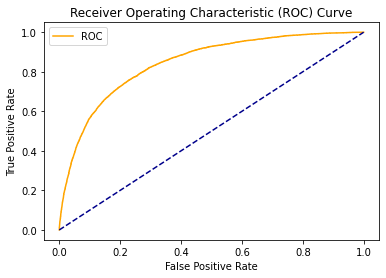

AUC-ROC : 0.84333


In [235]:
probs = vtc.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)
print("AUC-ROC :",round(auc,5))
#BEST: 0.83942
#KAGLE 0.82677

### 3º Modelo - **Random Forest**





In [236]:
# Randon Forest
rf1 = RandomForestClassifier(random_state=random_state, n_estimators=estimator)

rf1.fit(X_train, y_train)
rf1_y_val_pred = rf1.predict(X_test)

results = cross_val_score(rf1, X_train, y_train, cv = cv, 
                          scoring = 'precision')
intervalo_prec(results)

#Precisão média: 66.99%
#Intervalo de Precisão: [65.05% ~ 68.93%]

#Precisão média: 67.59%
#Intervalo de Precisão: [66.65% ~ 68.52%]

Precisão média: 67.47%
Intervalo de Precisão: [65.34% ~ 69.59%]


### 4º Modelo - **GradientBoostingClassifier** Retirando  variaveis com possível prob. **multicolineridade**

Ajuste de n_estimator para 500

In [237]:
#df_training_test_v4 = df_training_test.drop(['d1_albumin_max','d1_albumin_min','h1_albumin_max','h1_albumin_min'
#                                              ,'d1_bilirubin_max','d1_bilirubin_min','h1_bilirubin_max','h1_bilirubin_min'
#                                              ,'d1_bun_max','d1_bun_min','h1_bun_max','h1_bun_min'
#                                              ,'d1_creatinine_max','d1_creatinine_min','h1_creatinine_max','h1_creatinine_min'
#                                              ,'d1_glucose_max','d1_glucose_min','h1_glucose_max','h1_glucose_min'
#                                              #,'d1_heartrate_max','d1_heartrate_min','h1_heartrate_max','h1_heartrate_min'
#                                              #,'d1_hemaglobin_max','d1_hemaglobin_min','d1_hematocrit_max','d1_hematocrit_min'
#                                              #,'d1_pao2fio2ratio_max','d1_pao2fio2ratio_min','h1_pao2fio2ratio_max','h1_pao2fio2ratio_min'
#                                              #,'d1_arterial_ph_max','d1_arterial_ph_min','h1_arterial_ph_max','h1_arterial_ph_min'
#                                              ,'d1_resprate_max','d1_resprate_min','h1_resprate_max','h1_resprate_min'
#                                              ,'d1_sodium_max','d1_sodium_min','h1_sodium_max','h1_sodium_min'
#                                              ,'d1_temp_max','d1_temp_min','h1_temp_max','h1_temp_min'
#                                              ,'d1_wbc_max','d1_wbc_min','h1_wbc_max','h1_wbc_min'
#                                              ],axis = 1)
#
#df_unlabeled_test_v4 = df_unlabeled.drop(['d1_albumin_max','d1_albumin_min','h1_albumin_max','h1_albumin_min'
#                                              ,'d1_bilirubin_max','d1_bilirubin_min','h1_bilirubin_max','h1_bilirubin_min'
#                                              ,'d1_bun_max','d1_bun_min','h1_bun_max','h1_bun_min'
#                                              ,'d1_creatinine_max','d1_creatinine_min','h1_creatinine_max','h1_creatinine_min'
#                                              ,'d1_glucose_max','d1_glucose_min','h1_glucose_max','h1_glucose_min'
#                                              #,'d1_heartrate_max','d1_heartrate_min','h1_heartrate_max','h1_heartrate_min'
#                                              #,'d1_hemaglobin_max','d1_hemaglobin_min','d1_hematocrit_max','d1_hematocrit_min'
#                                              #,'d1_pao2fio2ratio_max','d1_pao2fio2ratio_min','h1_pao2fio2ratio_max','h1_pao2fio2ratio_min'
#                                              #,'d1_arterial_ph_max','d1_arterial_ph_min','h1_arterial_ph_max','h1_arterial_ph_min'
#                                              ,'d1_resprate_max','d1_resprate_min','h1_resprate_max','h1_resprate_min'
#                                              ,'d1_sodium_max','d1_sodium_min','h1_sodium_max','h1_sodium_min'
#                                              ,'d1_temp_max','d1_temp_min','h1_temp_max','h1_temp_min'
#                                              ,'d1_wbc_max','d1_wbc_min','h1_wbc_max','h1_wbc_min'
#                                              ],axis = 1)
#
#print(df_training_test_v4.shape)
#print(df_unlabeled_test_v4.shape)

In [238]:
df_training_test_v4 = df_training_test.drop([  'albumin_apache'
                                              ,'bilirubin_apache'
                                              ,'bun_apache'
                                              ,'creatinine_apache'
                                              ,'glucose_apache'
                                              #,'d1_glucose_max','d1_glucose_min','h1_glucose_max','h1_glucose_min'
                                              ,'resprate_apache'
                                              ,'sodium_apache'
                                              ,'temp_apache'
                                              ,'wbc_apache'
                                              ],axis = 1)

df_unlabeled_test_v4 = df_unlabeled_test.drop([ 'albumin_apache'
                                              ,'bilirubin_apache'
                                              ,'bun_apache'
                                              ,'creatinine_apache'
                                              ,'glucose_apache'
                                              #,'d1_glucose_max','d1_glucose_min','h1_glucose_max','h1_glucose_min'
                                              ,'resprate_apache'
                                              ,'sodium_apache'
                                              ,'temp_apache'
                                              ,'wbc_apache'
                                              ],axis = 1)

print(df_training_test_v4.shape)
print(df_unlabeled_test_v4.shape)

(130157, 191)
(10234, 191)


In [239]:
SEED = 14
np.random.seed(SEED)
cv = StratifiedKFold(n_splits = 5, shuffle = True)

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'
          .format((mean - 2*dv)*100, (mean + 2*dv)*100))

#semente   
random_state = 14

# creating independent features X and dependant feature Y
y = df_training_test_v4['diabetes_mellitus']

X = df_training_test_v4.drop('diabetes_mellitus',axis = 1)
#test = df_unlabeled_test_v4.drop('diabetes_mellitus',axis = 1)

# Split into training and validation set
X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(X, y, test_size = 0.20, random_state=SEED)

#Balanceamento não efetivo
#X_train, y_train = sm.fit_sample(X_train,y_train)
pd.Series(y_train_v4).value_counts()

0    81665
1    22460
Name: diabetes_mellitus, dtype: int64

In [ ]:
#Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state=random_state)

# Random Forest Classifier
RFC = RandomForestClassifier(n_estimators=estimator) #Valor ajustado

# Voting Classifier with soft voting 
vtc4 = VotingClassifier(estimators=[('rfc', RFC),('gbc',GBC)], voting='soft')
vtc4 = vtc4.fit(X_train_v4, y_train_v4)

#%prun 
vtc4_predict_y = vtc4.predict(X_test_v4)

results = cross_val_score(vtc4, X_train_v4, y_train_v4, cv = cv, 
                          scoring = 'precision')
intervalo_prec(results)

#Precisão média: 68.07%
#Intervalo de Precisão: [66.92% ~ 69.22%]

Precisão média: 68.50%
Intervalo de Precisão: [66.55% ~ 70.45%]


### 5º **LightGBM**

In [192]:
import lightgbm
from sklearn.preprocessing import LabelBinarizer

# creating independent features X and dependant feature Y
y = df_training_test['diabetes_mellitus']

X = df_training_test.drop('diabetes_mellitus',axis = 1)
#test = df_unlabeled_test.drop('diabetes_mellitus',axis = 1)

# Split into training and validation set
X_train_lgm, X_test_lgm, y_train_lgm, y_test_lgm = train_test_split(X, y, test_size = 0.20, random_state=SEED)

categorical_features = [c for c, col in enumerate(df_training_test.columns) if 'cat' in col]
categorical_features

[]

In [193]:
train_data = lightgbm.Dataset(X, label=y, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(X_test_lgm, label=y_test_lgm)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 53,
    'feature_fraction': 1,
    'bagging_fraction': 0.80,
    'bagging_freq': 5,
    'learning_rate': 0.20,
    'verbose': 0,
    'tree_learner': 'voting',
    'num_threads': 3,
    'random_state': random_state, 
    'min_data_in_leaf': 100
}

lgm = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=2000,
                       early_stopping_rounds=100
                     )

lgm_predict_y = lgm.predict(X_test)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is []



[1]	valid_0's auc: 0.817139
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.82754
[3]	valid_0's auc: 0.832941
[4]	valid_0's auc: 0.836792
[5]	valid_0's auc: 0.840338
[6]	valid_0's auc: 0.843128
[7]	valid_0's auc: 0.84663
[8]	valid_0's auc: 0.848822
[9]	valid_0's auc: 0.851728
[10]	valid_0's auc: 0.853876
[11]	valid_0's auc: 0.856305
[12]	valid_0's auc: 0.858208
[13]	valid_0's auc: 0.859749
[14]	valid_0's auc: 0.861613
[15]	valid_0's auc: 0.863253
[16]	valid_0's auc: 0.864795
[17]	valid_0's auc: 0.866261
[18]	valid_0's auc: 0.867659
[19]	valid_0's auc: 0.869302
[20]	valid_0's auc: 0.870766
[21]	valid_0's auc: 0.872521
[22]	valid_0's auc: 0.874477
[23]	valid_0's auc: 0.875723
[24]	valid_0's auc: 0.876719
[25]	valid_0's auc: 0.878572
[26]	valid_0's auc: 0.879557
[27]	valid_0's auc: 0.880515
[28]	valid_0's auc: 0.881494
[29]	valid_0's auc: 0.882478
[30]	valid_0's auc: 0.883308
[31]	valid_0's auc: 0.884182
[32]	valid_0's auc: 0.884917
[33]	valid_0's auc: 

In [194]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, lgm_predict_y) ** 0.5)

The rmse of prediction is: 0.21192054391901005


In [195]:
auc_list = []
recall_list = []

y_pred = lgm.predict(X_test, num_iteration=lgm.best_iteration)
y_pred = np.round_(y_pred, 0)
auc_list.append(roc_auc_score(y_test, y_pred))
#recall_list.append(recall_score(y_test, y_pred))

# Mean Metric
print(('Area Under the Curve mean: {}'.format(np.mean(auc_list))))
#print(('Recall mean: {}'.format(np.mean(recall_list))))

Area Under the Curve mean: 0.9660080506990327


### Ajustar hiperparametros do modelo

#### Primeira avaliação

In [ ]:
n_estimators = [100, 200, 300, 400, 500]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(random_state=random_state),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators, cv = 10)

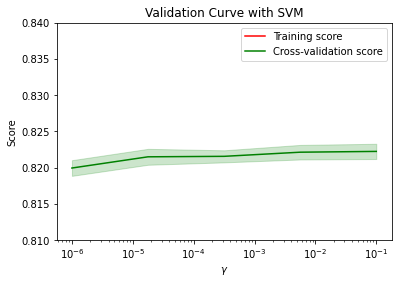

In [ ]:
train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

param_range = [100, 200, 300, 400, 500]

plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.81, 0.84)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 200, 300, 400, 500]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(random_state=random_state), hyperF, cv = 3, verbose = 1, 
                      n_jobs = 10)
bestF = gridF.fit(X_train, y_train)

In [ ]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):
    
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())
    
        # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

GridSearch_table_plot(bestF, "n_estimators", negative=False)

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_pool)

# visualize the training set predictions
# SHAP plots for all the data is very slow, so we'll only do it for a sample. Taking the head instead of a random sample is dangerous! 
shap.force_plot(explainer.expected_value,shap_values[0,:400], X_train.iloc[0,:400])

In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

n_estimators = [2, 5, 10, 15, 100]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RandomForestClassifier(random_state=random_state), hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

#### Segunda avaliação

In [ ]:
# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier ,VotingClassifier

print(__doc__)

Automatically created module for IPython interactive environment


In [ ]:
# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(RandomForestClassifier(random_state=random_state),
                  param_grid={'n_estimators': range(100, 500, 100)},
                  scoring=scoring, refit='AUC', return_train_score=True)
gs.fit(X = X_train, y = y_train)
results = gs.cv_results_

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("param_n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 500)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

## **Comparação dos Modelos** 

======================= Voting C ========================

ACURÁCIA:                 0.8294
SENSIBILIDADE:            0.3967
PRECISÃO:                 0.6794
F1-SCORE:                 0.5009
ERRO QUADRADO AJUSTADO:   0.3091
ROC SCORE:                0.6726
MATRIZ DE CONFUSÃO:      
 [[19361  1052]
 [ 3390  2229]]
===================== Random Forest =====================

ACURÁCIA:                 0.8248
SENSIBILIDADE:            0.3542
PRECISÃO:                 0.6813
F1-SCORE:                 0.466
ERRO QUADRADO AJUSTADO:   0.2827
ROC SCORE:                0.6543
MATRIZ DE CONFUSÃO:      
 [[19482   931]
 [ 3629  1990]]
===================== Voting C_v4 =======================

ACURÁCIA:                 0.8274
SENSIBILIDADE:            0.3817
PRECISÃO:                 0.6902
F1-SCORE:                 0.4915
ERRO QUADRADO AJUSTADO:   0.3015
ROC SCORE:                0.6669
MATRIZ DE CONFUSÃO:      
 [[19366   975]
 [ 3519  2172]]


**********************      ROC      *****************

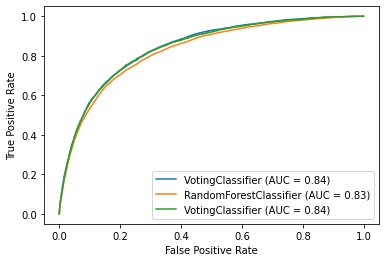

In [ ]:
print('======================= Voting C ========================\n')
model_performance(vtc, X_test, y_test, vtc_predict_y)
print('===================== Random Forest =====================\n')
model_performance(rf1, X_test, y_test, rf1_y_val_pred)
print('===================== Voting C_v4 =======================\n')
model_performance(vtc4, X_test_v4, y_test_v4, vtc4_predict_y)

print('\n\n**********************      ROC      **********************\n\n')
ax = plt.gca()

resp = metrics.plot_roc_curve(vtc, X_test, y_test, ax=ax)
resp = metrics.plot_roc_curve(rf1, X_test, y_test, ax=ax)
resp = metrics.plot_roc_curve(vtc4, X_test_v4, y_test_v4, ax=ax)
plt.show()

#BEST: 0.84
#KAGLE 0.83432

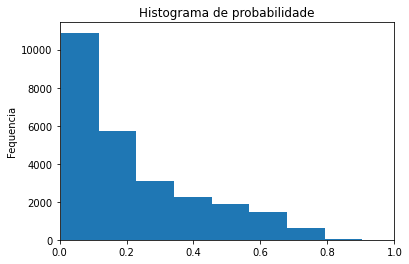

In [ ]:
plt.hist(probs, bins=8)
plt.xlim(0,1)
plt.title("Histograma de probabilidade")
plt.ylabel("Fequencia")
plt.show()

## **Selecionar Modelo para Submissão Final**

0    102006
1     28151
Name: diabetes_mellitus, dtype: int64


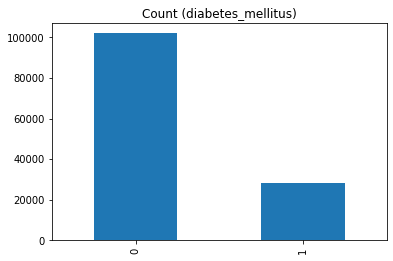

In [ ]:
print(df_training_test.diabetes_mellitus.value_counts())
df_training_test.diabetes_mellitus.value_counts().plot(kind='bar', title='Count (diabetes_mellitus)');

In [ ]:
print(df_training_test.shape)
print(df_unlabeled_test.shape)

(130157, 200)
(10234, 200)


In [ ]:
test = df_unlabeled_test
test1 = test.copy()

test.drop('diabetes_mellitus',axis = 1, inplace=True, errors='ignore')
test1.drop('diabetes_mellitus',axis = 1, inplace=True, errors='ignore')

In [ ]:
#test = df_unlabeled_test_v4
#test1 = test.copy()
#
#test.drop('diabetes_mellitus',axis = 1, inplace=True, errors='ignore')
#test1.drop('diabetes_mellitus',axis = 1, inplace=True, errors='ignore')

In [214]:
#file = 'submission_1.8.csv' #Submissão v8 com ajuste de mediana por idade nas variaveis com missing - n_estimator 150 Kagle Score: 0.82929
#file = 'submission_1.9.csv' #Submissão v9 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 160 (vtc1) Kagle Score:     0.82353
#file = 'submission_1.10.csv' #Submissão v10 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 160 (VTC4) Kagle Score:   0.79533
#file = 'submission_1.11.csv' #Submissão v11 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 500 (VTC1) Kagle Score:   0.82476
#file = 'submission_1.12.csv' #Submissão v12 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 500 (RF1) Kagle Score:    0.81032
#file = 'submission_1.13.csv' #Submissão v13 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 500 (RF1) Kagle Score:    0.79690
#file = 'submission_1.15.csv' #Submissão v15 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 160 (VTC1) Kagle Score:   0.83432
#file = 'submission_1.16.csv' #Submissão v16 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 170 e test_size em 20 (antes era 30) Kagle Score:   0.83122
#file = 'submission_1.17.csv' #Submissão v17 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 170 e test_size em 20 (antes era 30) Kagle Score:   0.83122
file = 'submission_1.18.csv' #Submissão v1 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 160 e test_size em 20 (antes era 30) nao zerando glucose missing - Kagle Score:   0.83122

test1["diabetes_mellitus"] = vtc.predict_proba(test)[:,1]
#test1["diabetes_mellitus"] = lgm.predict(test)
test1[["encounter_id","diabetes_mellitus"]].to_csv(file,index=False)
test1[["encounter_id","diabetes_mellitus"]].head()

encounter_id  diabetes_mellitus
0        144740           0.175185
1        141990           0.144889
2        142038           0.165032
3        138628           0.102908
4        141682           0.363350

In [211]:
#test1["diabetes_mellitus"] = vtc.predict_proba(test)[:,1]
test1["diabetes_mellitus"] = lgm.predict(test)
#test1[["encounter_id","diabetes_mellitus"]].to_csv(file,index=False)
test1[["encounter_id","diabetes_mellitus"]].head()

encounter_id  diabetes_mellitus
0        144740           0.000969
1        141990           0.000279
2        142038           0.001225
3        138628           0.000814
4        141682           0.000293

In [215]:
!kaggle competitions submit -c widsdatathon2021 -f submission_1.18.csv -m "Submissão v18 com ajuste de mediana por bmi_grp (classificacao global) nas variaveis com missing - n_estimator 170 e test_size em 20 (antes era 30) - Retirando missing zerados da glucose - VCT1"

100% 266k/266k [00:02<00:00, 113kB/s]
Successfully submitted to WiDS Datathon 2021